In [1]:
import os
import torch
from copy import deepcopy
import numpy as np
import xarray as xr
import pandas as pd
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
from sklearn import preprocessing
import zipfile
import shutil
from sklearn.preprocessing import StandardScaler
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
device

'cuda'

In [2]:
def set_seed(seed = 427):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)

In [3]:
class EarthDataSet(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data['sst'])

    def __getitem__(self, idx):   
        return (self.data['sst'][idx], self.data['t300'][idx], self.data['ua'][idx], self.data['va'][idx]), self.data['label'][idx]

In [4]:
def fit_data(data_list, fit=True):
    a,b,c,d = data_list[0].shape
    all_data = []
    for data in data_list:
        new_data = data.reshape(-1)
        all_data.append(new_data)
    all_data = np.stack(all_data,1)
    print(all_data.shape)
    if fit:
        standardScaler.fit(all_data)
        print("fit train data")
    all_data = standardScaler.transform(all_data)
    res_data = []
    for i in range(all_data.shape[1]):
        data = all_data[:,i].reshape(a,b,c,d)
        res_data.append(data)
    return res_data

In [5]:
def load_data():
    # CMIP data    
    train = xr.open_dataset('tcdata/enso_round1_train_20210201/CMIP_train.nc')
    label = xr.open_dataset('tcdata/enso_round1_train_20210201/CMIP_label.nc')    
   
    train_sst = train['sst'][:, :12].values.astype('float64')  # (4645, 12, 24, 72)
    train_t300 = train['t300'][:, :12].values.astype('float64')
    train_ua = train['ua'][:, :12].values.astype('float64')
    train_va = train['va'][:, :12].values.astype('float64')
    train_label = label['nino'][:, 12:36].values.astype('float64')

    train_ua = np.nan_to_num(train_ua) # trans nan to 0
    train_va = np.nan_to_num(train_va)
    train_t300 = np.nan_to_num(train_t300)
    train_sst = np.nan_to_num(train_sst)
    
#     data_list = [train_sst,train_t300,train_ua,train_va]
#     train_sst,train_t300,train_ua,train_va = fit_data(data_list, fit=True)

    # SODA data    
    train2 = xr.open_dataset('tcdata/enso_round1_train_20210201/SODA_train.nc')
    label2 = xr.open_dataset('tcdata/enso_round1_train_20210201/SODA_label.nc')
    
    train_sst2 = train2['sst'][:, :12].values.astype('float64')  # (100, 12, 24, 72)
    train_t3002 = train2['t300'][:, :12].values.astype('float64')
    train_ua2 = train2['ua'][:, :12].values.astype('float64')
    train_va2 = train2['va'][:, :12].values.astype('float64')
    train_label2 = label2['nino'][:, 12:36].values.astype('float64')
    
    train_sst2 = np.nan_to_num(train_sst2) # trans nan to 0
    train_t3002 = np.nan_to_num(train_t3002)
    train_ua2 = np.nan_to_num(train_ua2)
    train_va2 = np.nan_to_num(train_va2)
    
#     data_list = [train_sst2,train_t3002,train_ua2,train_va2]
#     train_sst2,train_t3002,train_ua2,train_va2 = fit_data(data_list, fit=False)

    dict_cmip = {
        'sst':train_sst,
        't300':train_t300,
        'ua':train_ua,
        'va': train_va,
        'label': train_label}
    dict_soda = {
        'sst':train_sst2,
        't300':train_t3002,
        'ua':train_ua2,
        'va': train_va2,
        'label': train_label2}
    
    cmip_dataset = EarthDataSet(dict_cmip)
    soda_dataset = EarthDataSet(dict_soda)
    
    train_1, valid_1 = random_split(cmip_dataset, [4545, 100])
    train_2, valid_2 = random_split(soda_dataset, [90, 10])
    
    train_dataset = train_1 + train_2 + train_2 + train_2 + train_2 + train_2 
    valid_dataset = valid_2 + valid_1 + valid_2 + valid_2 + valid_2 + valid_2
    
    return train_dataset, valid_dataset

In [6]:
set_seed()
standardScaler = StandardScaler()
train_dataset, valid_dataset = load_data()      
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [7]:
def coreff(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    c1 = sum((x - x_mean) * (y - y_mean))
    c2 = sum((x - x_mean)**2) * sum((y - y_mean)**2)
    return c1/np.sqrt(c2)

def rmse(preds, y):
    r = np.sqrt(sum((preds - y)**2) / preds.shape[0])
    return r

def eval_score(preds, label):
    acskill_socre = 0
    rmse_score = 0
    a = [1.5]*4 + [2]*7 + [3]*7 + [4]*6
    for i in range(24):
        r = rmse(preds[:, i], label[:, i], ) # T时刻 (100,)
        cor = coreff(preds[:, i], label[:, i], )
    
        rmse_score += r
        acskill_socre += a[i] * np.log(i+1) * cor
    print("acskill_socre:{}, rmse_score:{}".format(2/3*acskill_socre, rmse_score))
    return 2/3 * acskill_socre - rmse_score

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def train(num_epochs):
    best_score = -99
    loss_epoch = []
    score_epoch = []
    epoch = -1
    model.eval()
    y_true, y_pred = [], []
    for step, ((sst, t300, ua, va), label) in enumerate(valid_loader):
        sst = sst.to(device).float()
        t300 = t300.to(device).float()
        ua = ua.to(device).float()
        va = va.to(device).float()
        label = label.to(device).float()
        preds = model(sst, t300, ua, va)

        y_pred.append(preds)
        y_true.append(label)

    y_true = torch.cat(y_true, axis=0).cpu().detach().numpy()
    y_pred = torch.cat(y_pred, axis=0).cpu().detach().numpy()
    x_month = np.arange(24)
    score = eval_score(y_true, y_pred)
    print('Epoch: {}, Valid Score: {}\n'.format(epoch+1,score))    
        
    for epoch in range(num_epochs):
        model.train()
        all_loss = []
        for step, ((sst, t300, ua, va), label) in enumerate(train_loader):                
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            optimizer.zero_grad()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)
            loss = loss_fn(preds, label)
            loss.backward()
            optimizer.step()
            all_loss.append(loss.item())
            if step%20 == 0:
                print('Step: {}, Train Loss: {}'.format(step, loss))
        print('Epoch: {}, Train loss: {}'.format(epoch+1, np.mean(all_loss)))
        loss_epoch.append(np.mean(all_loss))

        model.eval()
        y_true, y_pred = [], []
        for step, ((sst, t300, ua, va), label) in enumerate(valid_loader):
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)

            y_pred.append(preds)
            y_true.append(label)

        y_true = torch.cat(y_true, axis=0).cpu().detach().numpy()
        y_pred = torch.cat(y_pred, axis=0).cpu().detach().numpy()
        x_month = np.arange(24)
        score = eval_score(y_true, y_pred)
        score_epoch.append(score)
        print('Epoch: {}, Valid Score: {}'.format(epoch+1,score))
        
        torch.save(model.state_dict(), './models/basemodel_epoch_{}.pt'.format(epoch+1))
        if score > best_score:
            torch.save(model.state_dict(), './models/basemodel_best.pt')
            print('Model saved successfully')
            best_score = score
            
        # figure
        plt.figure(figsize = (10,5))
        for i in range(23):
            plt.subplot(5,5,i+1)
            plt.plot(x_month, y_true[i],color='red')
            plt.plot(x_month, y_pred[i],color='blue')
        plt.subplot(5,5,24)
        plt.plot(np.arange(len(loss_epoch))[:20],loss_epoch[-20:])
        plt.subplot(5,5,25)
        plt.plot(np.arange(len(score_epoch)),score_epoch)
        plt.tight_layout()
        plt.show()
        

In [10]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(4,8))) 
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(4,8))) 
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(4,8))) 
        self.conv4 = nn.Sequential(nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(4,8))) 
        
        self.batch_norm = nn.BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True)
#         self.lstm = nn.LSTM(input_size = 1540 * 4, hidden_size = 256, num_layers=2, batch_first=True, bidirectional=False)
        self.avgpool = nn.AdaptiveAvgPool2d((12, 128))
        self.linear0 = nn.Linear(12*128, 64)
        self.tanh = nn.Tanh()
        self.linear = nn.Linear(64, 24)

    def forward(self, sst, t300, ua, va):
        sst = self.conv1(sst)  # batch * 12 * (24 - 2) * (72 -2)
        t300 = self.conv2(t300)
        ua = self.conv3(ua)
        va = self.conv4(va)

        sst = torch.flatten(sst, start_dim=2)  # batch * 12 * 1540
        t300 = torch.flatten(t300, start_dim=2)
        ua = torch.flatten(ua, start_dim=2)
        va = torch.flatten(va, start_dim=2)  
        
        x = torch.cat([sst, t300, ua, va], dim=-1) # batch * 12 * (1540 * 4)
        x = self.batch_norm(x)
#         x, (h_n, c_n) = self.lstm(x)
#         x = x[:,-1]
        x = self.avgpool(x).squeeze(dim=-2)
        x = torch.flatten(x, start_dim=1)
        x = self.linear0(x)
        x = self.tanh(x)
        x = self.linear(x)
        return x

In [11]:
model = CNN_Model()
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
optimizer = torch.optim.Adam(model.parameters(), lr=6e-5)
loss_fn = nn.MSELoss()

model = model.to(device)
loss_fn = loss_fn.to(device)

In [12]:
print('{} : all params: {:4f}M'.format(model._get_name(), sum(p.numel() for p in model.parameters()) / 1000 / 1000))

CNN_Model : all params: 0.118432M


In [13]:
model

CNN_Model(
  (conv1): Sequential(
    (0): Conv2d(12, 12, kernel_size=(4, 8), stride=(1, 1))
  )
  (conv2): Sequential(
    (0): Conv2d(12, 12, kernel_size=(4, 8), stride=(1, 1))
  )
  (conv3): Sequential(
    (0): Conv2d(12, 12, kernel_size=(4, 8), stride=(1, 1))
  )
  (conv4): Sequential(
    (0): Conv2d(12, 12, kernel_size=(4, 8), stride=(1, 1))
  )
  (batch_norm): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avgpool): AdaptiveAvgPool2d(output_size=(12, 128))
  (linear0): Linear(in_features=1536, out_features=64, bias=True)
  (tanh): Tanh()
  (linear): Linear(in_features=64, out_features=24, bias=True)
)

acskill_socre:1.5006341458669321, rmse_score:19.553780293527804
Epoch: 0, Valid Score: -18.053146147660872

Step: 0, Train Loss: 0.5592682361602783
Step: 20, Train Loss: 0.571924090385437
Step: 40, Train Loss: 0.6083695292472839
Step: 60, Train Loss: 0.7017056345939636
Step: 80, Train Loss: 0.5811331272125244
Step: 100, Train Loss: 0.5389506816864014
Step: 120, Train Loss: 0.5464925169944763
Step: 140, Train Loss: 0.5331182479858398
Epoch: 1, Train loss: 0.6088597546717164
acskill_socre:41.4928393164654, rmse_score:17.357642612907053
Epoch: 1, Valid Score: 24.135196703558346
Model saved successfully


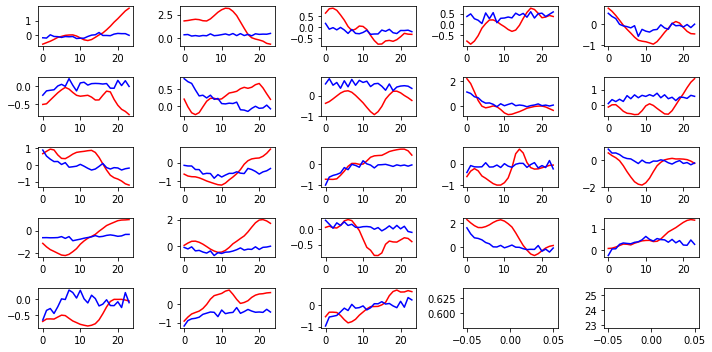

Step: 0, Train Loss: 0.5041859149932861
Step: 20, Train Loss: 0.4809882640838623
Step: 40, Train Loss: 0.5184366703033447
Step: 60, Train Loss: 0.5058497190475464
Step: 80, Train Loss: 0.575363278388977
Step: 100, Train Loss: 0.5021741986274719
Step: 120, Train Loss: 0.5703275799751282
Step: 140, Train Loss: 0.8687054514884949
Epoch: 2, Train loss: 0.5168374993239239
acskill_socre:44.7738973375341, rmse_score:16.926332473597853
Epoch: 2, Valid Score: 27.84756486393625
Model saved successfully


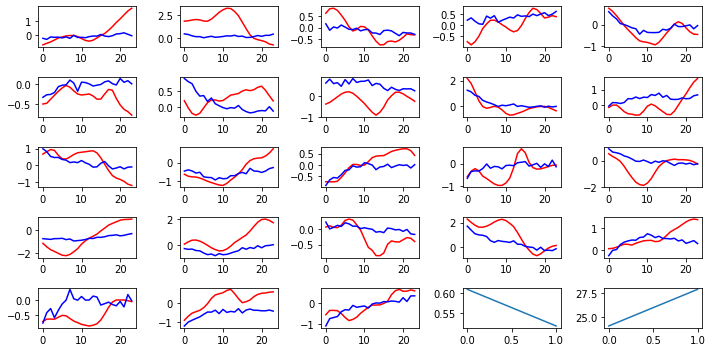

Step: 0, Train Loss: 0.4919765889644623
Step: 20, Train Loss: 0.47098076343536377
Step: 40, Train Loss: 0.4598345160484314
Step: 60, Train Loss: 0.4073534905910492
Step: 80, Train Loss: 0.5354925990104675
Step: 100, Train Loss: 0.5513828992843628
Step: 120, Train Loss: 0.4064830243587494
Step: 140, Train Loss: 0.35132932662963867
Epoch: 3, Train loss: 0.48517259253058465
acskill_socre:46.369587950090626, rmse_score:16.632827427818878
Epoch: 3, Valid Score: 29.736760522271748
Model saved successfully


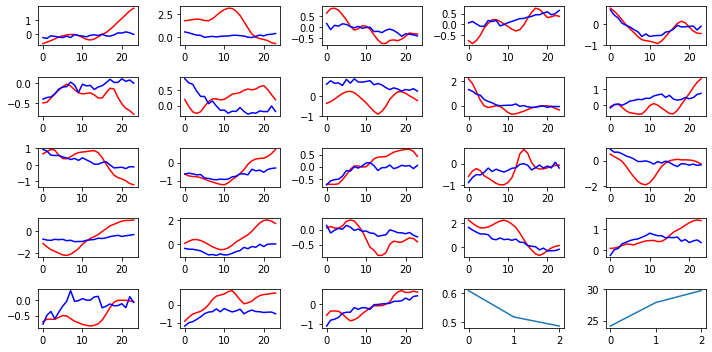

Step: 0, Train Loss: 0.4642494320869446
Step: 20, Train Loss: 0.37166500091552734
Step: 40, Train Loss: 0.6362432837486267
Step: 60, Train Loss: 0.5950084924697876
Step: 80, Train Loss: 0.6089252233505249
Step: 100, Train Loss: 0.352192223072052
Step: 120, Train Loss: 0.46194952726364136
Step: 140, Train Loss: 0.5473326444625854
Epoch: 4, Train loss: 0.467901958022148
acskill_socre:47.86418910657023, rmse_score:16.304750740492985
Epoch: 4, Valid Score: 31.559438366077245
Model saved successfully


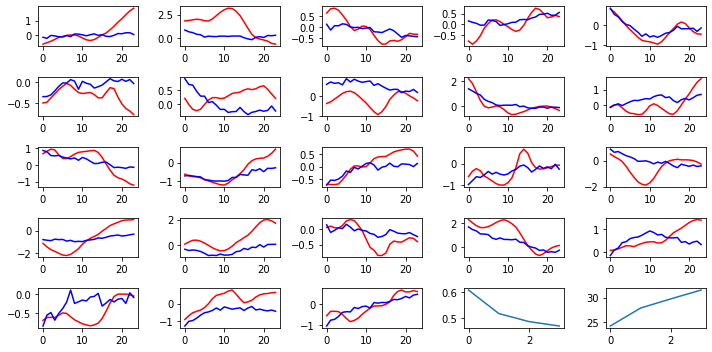

Step: 0, Train Loss: 0.5376607775688171
Step: 20, Train Loss: 0.47207707166671753
Step: 40, Train Loss: 0.3832119405269623
Step: 60, Train Loss: 0.3605729043483734
Step: 80, Train Loss: 0.5008326768875122
Step: 100, Train Loss: 0.48718056082725525
Step: 120, Train Loss: 0.38313478231430054
Step: 140, Train Loss: 0.5801233053207397
Epoch: 5, Train loss: 0.4569871082047748
acskill_socre:49.355799934150184, rmse_score:16.025692163806063
Epoch: 5, Valid Score: 33.33010777034412
Model saved successfully


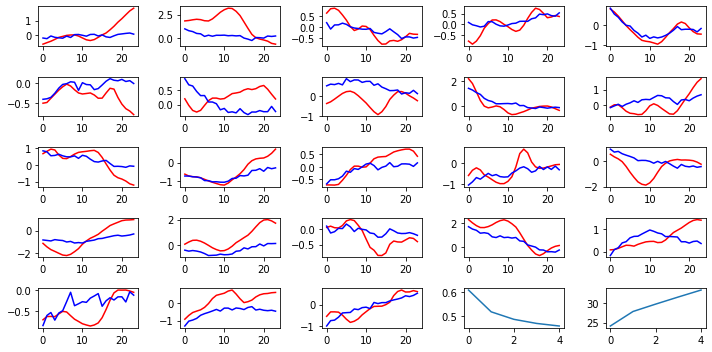

Step: 0, Train Loss: 0.49705010652542114
Step: 20, Train Loss: 0.5315365791320801
Step: 40, Train Loss: 0.5686823129653931
Step: 60, Train Loss: 0.5448417663574219
Step: 80, Train Loss: 0.32819199562072754
Step: 100, Train Loss: 0.45801299810409546
Step: 120, Train Loss: 0.41485852003097534
Step: 140, Train Loss: 0.45926469564437866
Epoch: 6, Train loss: 0.4426274635609548
acskill_socre:51.4187907861654, rmse_score:15.768752369344531
Epoch: 6, Valid Score: 35.65003841682087
Model saved successfully


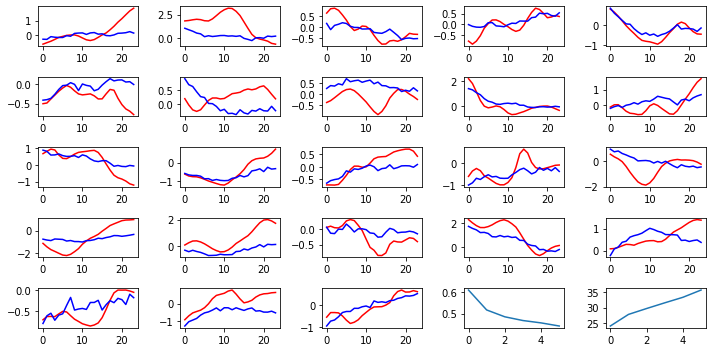

Step: 0, Train Loss: 0.4252323806285858
Step: 20, Train Loss: 0.46654582023620605
Step: 40, Train Loss: 0.2592431902885437
Step: 60, Train Loss: 0.44591259956359863
Step: 80, Train Loss: 0.5701069831848145
Step: 100, Train Loss: 0.48947733640670776
Step: 120, Train Loss: 0.47290492057800293
Step: 140, Train Loss: 0.4224625527858734
Epoch: 7, Train loss: 0.4315945302984517
acskill_socre:53.633474794603984, rmse_score:15.438365702680121
Epoch: 7, Valid Score: 38.19510909192386
Model saved successfully


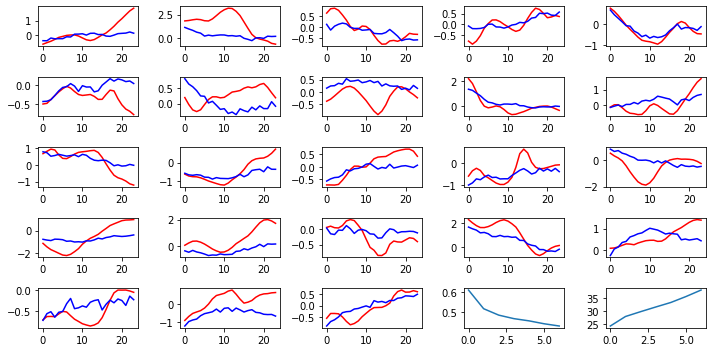

Step: 0, Train Loss: 0.36601853370666504
Step: 20, Train Loss: 0.3787483870983124
Step: 40, Train Loss: 0.3710727095603943
Step: 60, Train Loss: 0.36711740493774414
Step: 80, Train Loss: 0.47996991872787476
Step: 100, Train Loss: 0.3370749354362488
Step: 120, Train Loss: 0.30874162912368774
Step: 140, Train Loss: 0.44247421622276306
Epoch: 8, Train loss: 0.42491417582247665
acskill_socre:53.17530415741648, rmse_score:15.393367864086049
Epoch: 8, Valid Score: 37.78193629333043


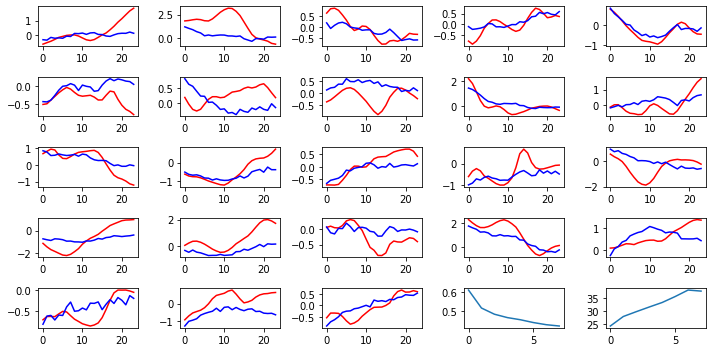

Step: 0, Train Loss: 0.3497841954231262
Step: 20, Train Loss: 0.2677915692329407
Step: 40, Train Loss: 0.3609163165092468
Step: 60, Train Loss: 0.581073522567749
Step: 80, Train Loss: 0.40306374430656433
Step: 100, Train Loss: 0.5153014659881592
Step: 120, Train Loss: 0.3251550793647766
Step: 140, Train Loss: 0.4909689426422119
Epoch: 9, Train loss: 0.41549847725850003
acskill_socre:53.48712973061271, rmse_score:15.26222497270636
Epoch: 9, Valid Score: 38.224904757906344
Model saved successfully


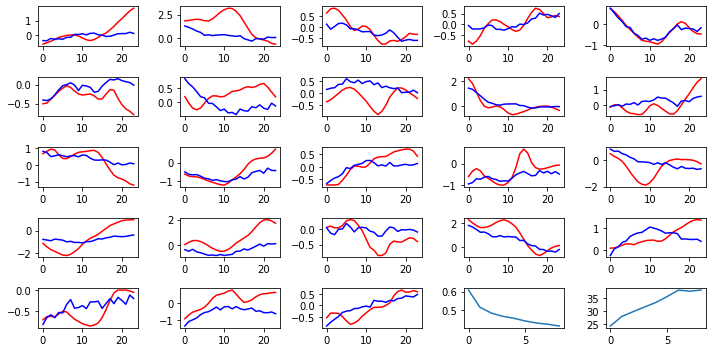

Step: 0, Train Loss: 0.2922350764274597
Step: 20, Train Loss: 0.3384796380996704
Step: 40, Train Loss: 0.5671112537384033
Step: 60, Train Loss: 0.35947513580322266
Step: 80, Train Loss: 0.4965347945690155
Step: 100, Train Loss: 0.4122407138347626
Step: 120, Train Loss: 0.35266822576522827
Step: 140, Train Loss: 0.46330496668815613
Epoch: 10, Train loss: 0.4097089393503347
acskill_socre:52.83860869223111, rmse_score:15.247843358369753
Epoch: 10, Valid Score: 37.590765333861356


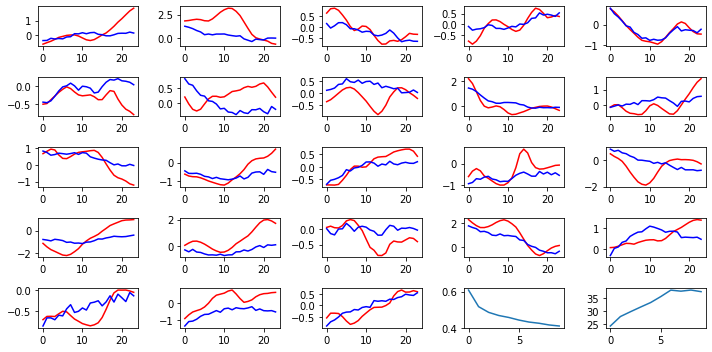

Step: 0, Train Loss: 0.4280548095703125
Step: 20, Train Loss: 0.5123366117477417
Step: 40, Train Loss: 0.3482215404510498
Step: 60, Train Loss: 0.42973989248275757
Step: 80, Train Loss: 0.3846871852874756
Step: 100, Train Loss: 0.4804384708404541
Step: 120, Train Loss: 0.3968815207481384
Step: 140, Train Loss: 0.3651279807090759
Epoch: 11, Train loss: 0.40437270102986866
acskill_socre:54.03030592648819, rmse_score:15.19553634754201
Epoch: 11, Valid Score: 38.83476957894618
Model saved successfully


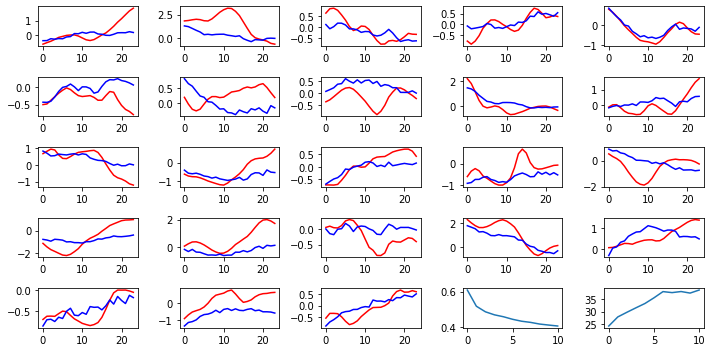

Step: 0, Train Loss: 0.2994561195373535
Step: 20, Train Loss: 0.43804821372032166
Step: 40, Train Loss: 0.2821308374404907
Step: 60, Train Loss: 0.32159027457237244
Step: 80, Train Loss: 0.46200913190841675
Step: 100, Train Loss: 0.34137627482414246
Step: 120, Train Loss: 0.5407753586769104
Step: 140, Train Loss: 0.3925512731075287
Epoch: 12, Train loss: 0.3970917838678998
acskill_socre:54.70269476794068, rmse_score:15.045525903490141
Epoch: 12, Valid Score: 39.65716886445054
Model saved successfully


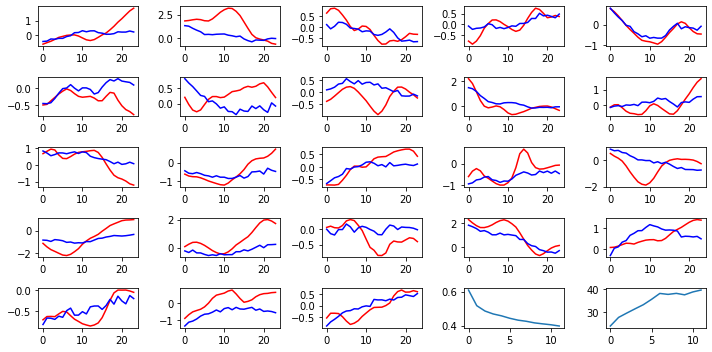

Step: 0, Train Loss: 0.3825393319129944
Step: 20, Train Loss: 0.522192120552063
Step: 40, Train Loss: 0.3837061822414398
Step: 60, Train Loss: 0.41987109184265137
Step: 80, Train Loss: 0.5152773857116699
Step: 100, Train Loss: 0.2531566619873047
Step: 120, Train Loss: 0.39277705550193787
Step: 140, Train Loss: 0.329874187707901
Epoch: 13, Train loss: 0.3929886519908905
acskill_socre:53.93363901680693, rmse_score:15.074863036486395
Epoch: 13, Valid Score: 38.85877598032053


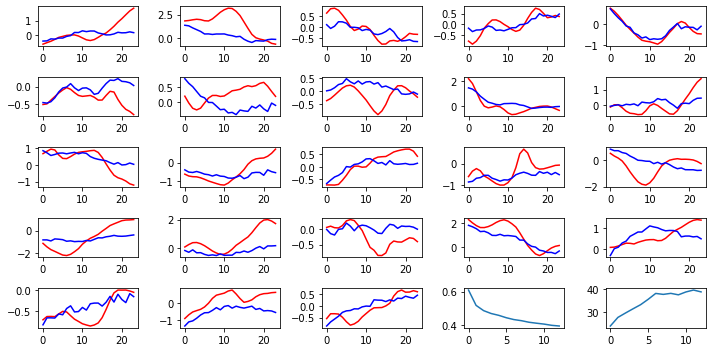

Step: 0, Train Loss: 0.33711618185043335
Step: 20, Train Loss: 0.4569757878780365
Step: 40, Train Loss: 0.4191998243331909
Step: 60, Train Loss: 0.30397725105285645
Step: 80, Train Loss: 0.3398936688899994
Step: 100, Train Loss: 0.31353920698165894
Step: 120, Train Loss: 0.37979620695114136
Step: 140, Train Loss: 0.3832685947418213
Epoch: 14, Train loss: 0.389660152660054
acskill_socre:52.156867414329284, rmse_score:15.23250563212359
Epoch: 14, Valid Score: 36.92436178220569


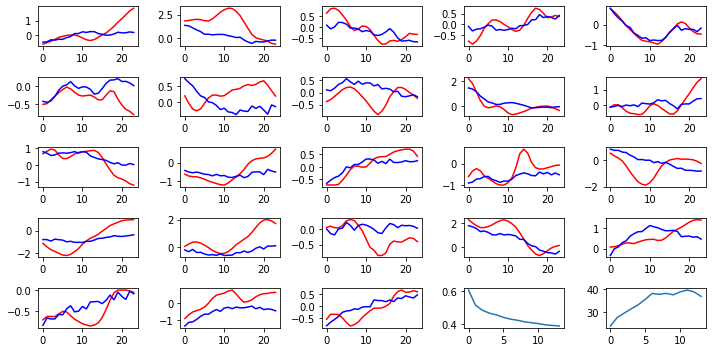

Step: 0, Train Loss: 0.4970118999481201
Step: 20, Train Loss: 0.3031647205352783
Step: 40, Train Loss: 0.5832905769348145
Step: 60, Train Loss: 0.4406813383102417
Step: 80, Train Loss: 0.4143070578575134
Step: 100, Train Loss: 0.403557151556015
Step: 120, Train Loss: 0.31602731347084045
Step: 140, Train Loss: 0.4062677323818207
Epoch: 15, Train loss: 0.3851041881142149
acskill_socre:55.7316844816208, rmse_score:14.943735120034304
Epoch: 15, Valid Score: 40.7879493615865
Model saved successfully


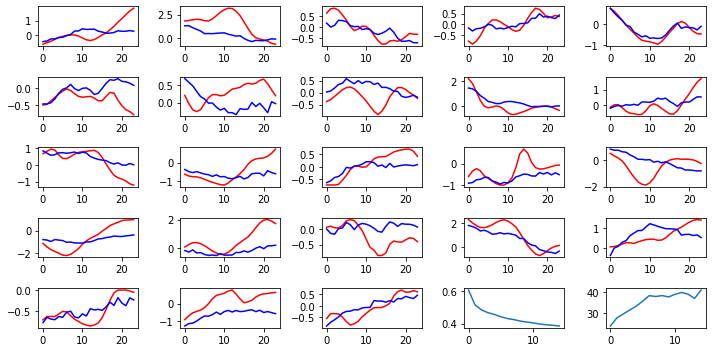

Step: 0, Train Loss: 0.32057052850723267
Step: 20, Train Loss: 0.502189040184021
Step: 40, Train Loss: 0.4118017554283142
Step: 60, Train Loss: 0.26942795515060425
Step: 80, Train Loss: 0.44175517559051514
Step: 100, Train Loss: 0.3422180414199829
Step: 120, Train Loss: 0.3528903126716614
Step: 140, Train Loss: 0.36312398314476013
Epoch: 16, Train loss: 0.37987622694604717
acskill_socre:55.589015118502616, rmse_score:14.928341893235848
Epoch: 16, Valid Score: 40.66067322526677


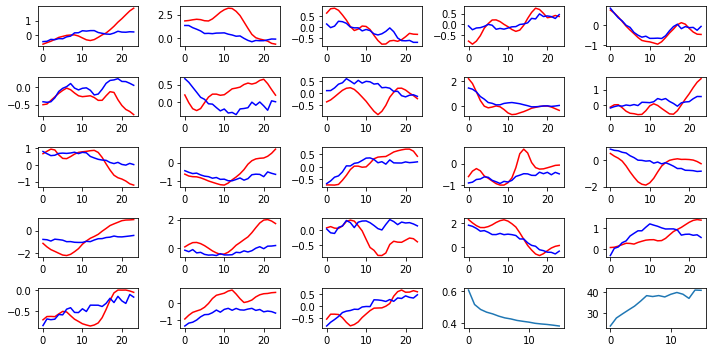

Step: 0, Train Loss: 0.35594528913497925
Step: 20, Train Loss: 0.27054521441459656
Step: 40, Train Loss: 0.46815070509910583
Step: 60, Train Loss: 0.4363071918487549
Step: 80, Train Loss: 0.3587256669998169
Step: 100, Train Loss: 0.5286423563957214
Step: 120, Train Loss: 0.2947752773761749
Step: 140, Train Loss: 0.36931324005126953
Epoch: 17, Train loss: 0.3748658731295045
acskill_socre:52.95655481132589, rmse_score:15.196694082794282
Epoch: 17, Valid Score: 37.759860728531606


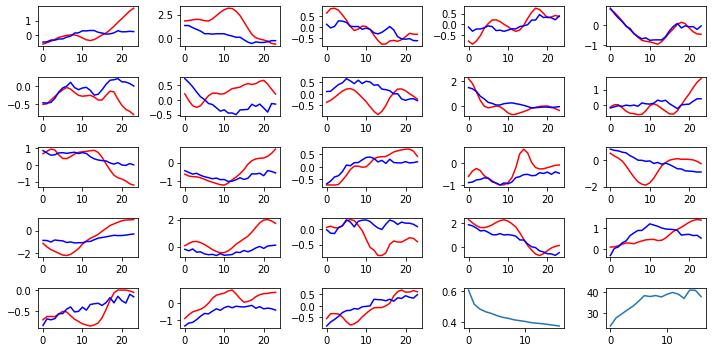

Step: 0, Train Loss: 0.2781160771846771
Step: 20, Train Loss: 0.3282839059829712
Step: 40, Train Loss: 0.38569945096969604
Step: 60, Train Loss: 0.5061788558959961
Step: 80, Train Loss: 0.2401466816663742
Step: 100, Train Loss: 0.2446393072605133
Step: 120, Train Loss: 0.27256983518600464
Step: 140, Train Loss: 0.35649871826171875
Epoch: 18, Train loss: 0.37306385995096464
acskill_socre:54.3501760456129, rmse_score:15.042332296804295
Epoch: 18, Valid Score: 39.3078437488086


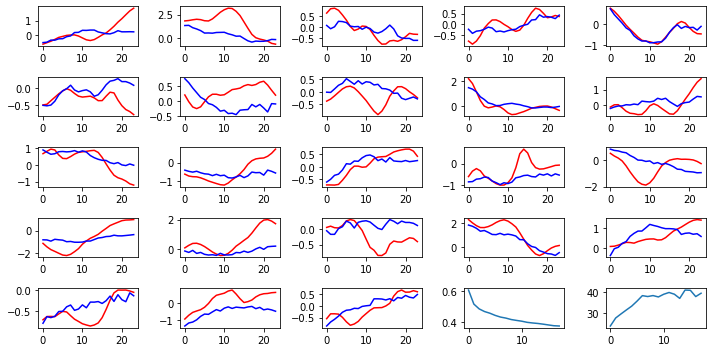

Step: 0, Train Loss: 0.39981865882873535
Step: 20, Train Loss: 0.30117693543434143
Step: 40, Train Loss: 0.3504585027694702
Step: 60, Train Loss: 0.2529160976409912
Step: 80, Train Loss: 0.34320366382598877
Step: 100, Train Loss: 0.33519482612609863
Step: 120, Train Loss: 0.4710729122161865
Step: 140, Train Loss: 0.34585174918174744
Epoch: 19, Train loss: 0.36795220557291797
acskill_socre:54.21419896609983, rmse_score:15.047205814556646
Epoch: 19, Valid Score: 39.16699315154318


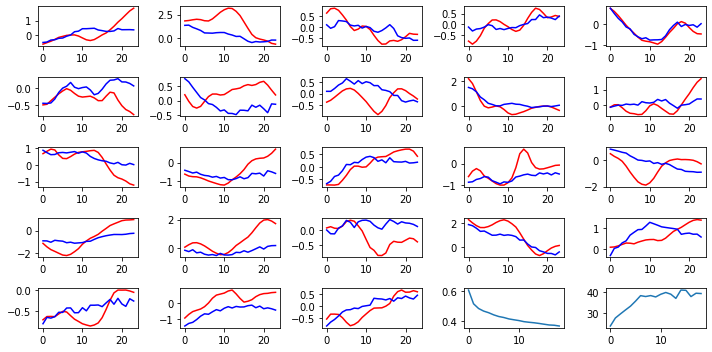

Step: 0, Train Loss: 0.3416057229042053
Step: 20, Train Loss: 0.2943227291107178
Step: 40, Train Loss: 0.33140820264816284
Step: 60, Train Loss: 0.23352065682411194
Step: 80, Train Loss: 0.36094725131988525
Step: 100, Train Loss: 0.2688743770122528
Step: 120, Train Loss: 0.3596150577068329
Step: 140, Train Loss: 0.3798494338989258
Epoch: 20, Train loss: 0.36432065677111314
acskill_socre:52.63780668074489, rmse_score:15.105047526466798
Epoch: 20, Valid Score: 37.53275915427809


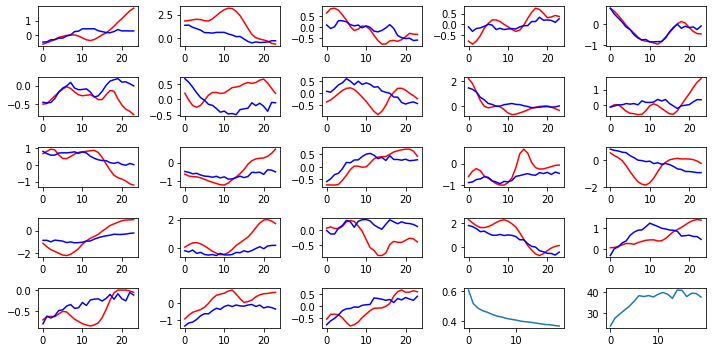

Step: 0, Train Loss: 0.3736259937286377
Step: 20, Train Loss: 0.3714149594306946
Step: 40, Train Loss: 0.38461801409721375
Step: 60, Train Loss: 0.4114686846733093
Step: 80, Train Loss: 0.3870651125907898
Step: 100, Train Loss: 0.3690152168273926
Step: 120, Train Loss: 0.27807074785232544
Step: 140, Train Loss: 0.46850210428237915
Epoch: 21, Train loss: 0.36051328072122707
acskill_socre:54.18792760633828, rmse_score:15.09670950601896
Epoch: 21, Valid Score: 39.09121810031932


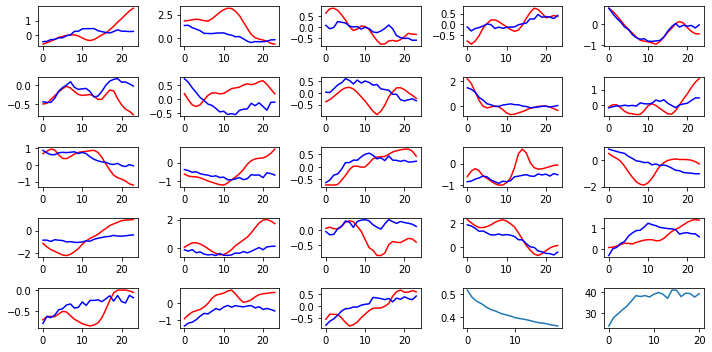

Step: 0, Train Loss: 0.35017532110214233
Step: 20, Train Loss: 0.3568495213985443
Step: 40, Train Loss: 0.2889726161956787
Step: 60, Train Loss: 0.418393611907959
Step: 80, Train Loss: 0.33540719747543335
Step: 100, Train Loss: 0.38171112537384033
Step: 120, Train Loss: 0.34703850746154785
Step: 140, Train Loss: 0.37321025133132935
Epoch: 22, Train loss: 0.35867993600049597
acskill_socre:53.86288146862683, rmse_score:15.117627717381211
Epoch: 22, Valid Score: 38.74525375124562


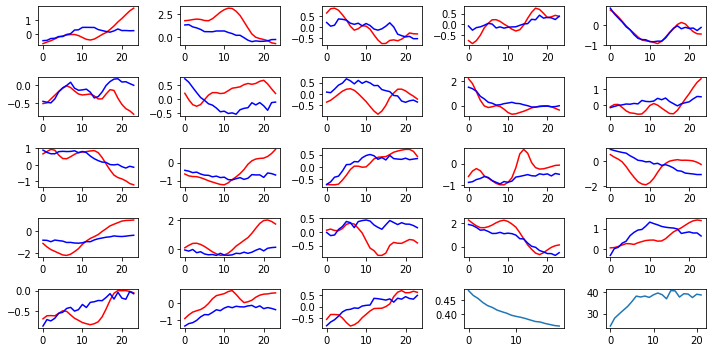

Step: 0, Train Loss: 0.3296529948711395
Step: 20, Train Loss: 0.3430647850036621
Step: 40, Train Loss: 0.32138940691947937
Step: 60, Train Loss: 0.4609045386314392
Step: 80, Train Loss: 0.34293287992477417
Step: 100, Train Loss: 0.26271647214889526
Step: 120, Train Loss: 0.34018513560295105
Step: 140, Train Loss: 0.25467997789382935
Epoch: 23, Train loss: 0.3542515667760448
acskill_socre:55.95627344853166, rmse_score:14.930099413734442
Epoch: 23, Valid Score: 41.02617403479722
Model saved successfully


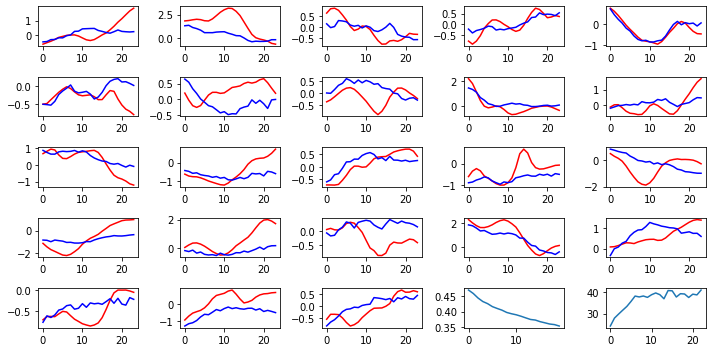

Step: 0, Train Loss: 0.3872811496257782
Step: 20, Train Loss: 0.3148985207080841
Step: 40, Train Loss: 0.3476611077785492
Step: 60, Train Loss: 0.32193905115127563
Step: 80, Train Loss: 0.24431060254573822
Step: 100, Train Loss: 0.26455581188201904
Step: 120, Train Loss: 0.29446205496788025
Step: 140, Train Loss: 0.42775630950927734
Epoch: 24, Train loss: 0.34964811858857514
acskill_socre:54.29861173168642, rmse_score:15.037076422486209
Epoch: 24, Valid Score: 39.26153530920021


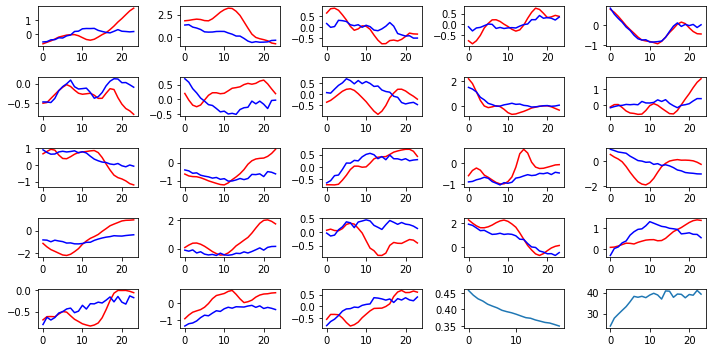

Step: 0, Train Loss: 0.28037118911743164
Step: 20, Train Loss: 0.3125618100166321
Step: 40, Train Loss: 0.31558337807655334
Step: 60, Train Loss: 0.4433220326900482
Step: 80, Train Loss: 0.37388962507247925
Step: 100, Train Loss: 0.29212576150894165
Step: 120, Train Loss: 0.2571307420730591
Step: 140, Train Loss: 0.47966670989990234
Epoch: 25, Train loss: 0.34753688904130536
acskill_socre:53.191120838965915, rmse_score:15.196053510473421
Epoch: 25, Valid Score: 37.995067328492496


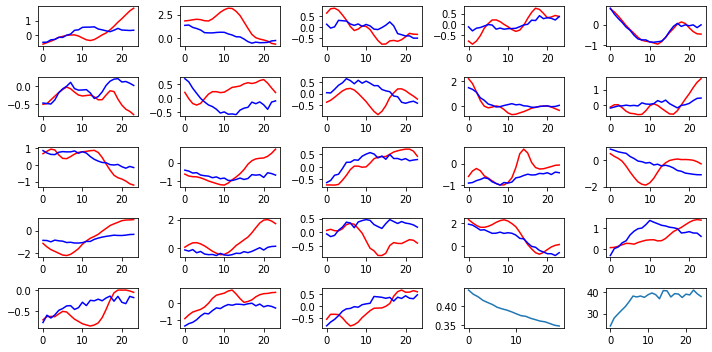

Step: 0, Train Loss: 0.2809745967388153
Step: 20, Train Loss: 0.27530771493911743
Step: 40, Train Loss: 0.3010537624359131
Step: 60, Train Loss: 0.3988057076931
Step: 80, Train Loss: 0.3538031578063965
Step: 100, Train Loss: 0.31853556632995605
Step: 120, Train Loss: 0.44502171874046326
Step: 140, Train Loss: 0.3153454065322876
Epoch: 26, Train loss: 0.3452327054017668
acskill_socre:54.880287325159216, rmse_score:14.96335991113078
Epoch: 26, Valid Score: 39.916927414028436


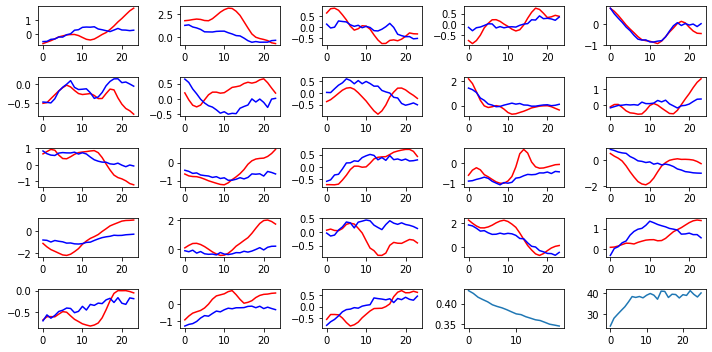

Step: 0, Train Loss: 0.3360633850097656
Step: 20, Train Loss: 0.3162902295589447
Step: 40, Train Loss: 0.4514073133468628
Step: 60, Train Loss: 0.3508567214012146
Step: 80, Train Loss: 0.410331130027771
Step: 100, Train Loss: 0.2920757532119751
Step: 120, Train Loss: 0.3362651765346527
Step: 140, Train Loss: 0.31459149718284607
Epoch: 27, Train loss: 0.3408468449666242
acskill_socre:54.71470463201399, rmse_score:15.056130296755883
Epoch: 27, Valid Score: 39.65857433525811


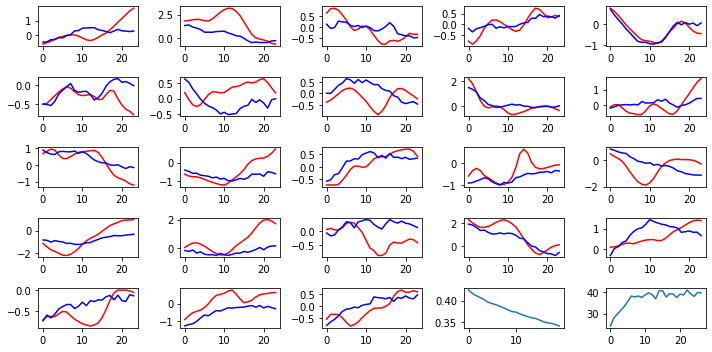

Step: 0, Train Loss: 0.3297787308692932
Step: 20, Train Loss: 0.21261081099510193
Step: 40, Train Loss: 0.4062219560146332
Step: 60, Train Loss: 0.32484114170074463
Step: 80, Train Loss: 0.2691078782081604
Step: 100, Train Loss: 0.2849162220954895
Step: 120, Train Loss: 0.2996147572994232
Step: 140, Train Loss: 0.2860000431537628
Epoch: 28, Train loss: 0.3380163245520015
acskill_socre:55.5215174222443, rmse_score:14.987889036201016
Epoch: 28, Valid Score: 40.53362838604328


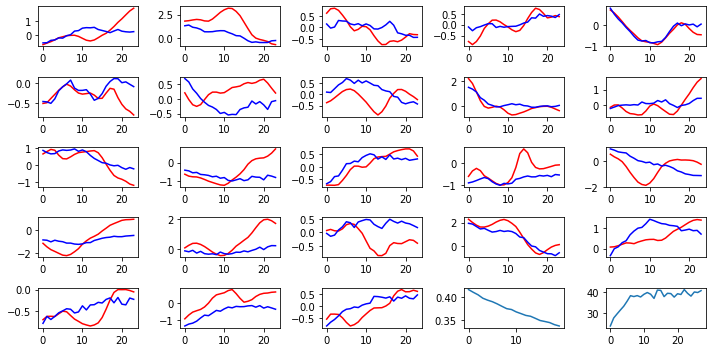

Step: 0, Train Loss: 0.41411346197128296
Step: 20, Train Loss: 0.21659180521965027
Step: 40, Train Loss: 0.4582403600215912
Step: 60, Train Loss: 0.276511013507843
Step: 80, Train Loss: 0.21452465653419495
Step: 100, Train Loss: 0.3224005699157715
Step: 120, Train Loss: 0.28908273577690125
Step: 140, Train Loss: 0.29003965854644775
Epoch: 29, Train loss: 0.336639939409912
acskill_socre:53.91272231783643, rmse_score:15.125334588933082
Epoch: 29, Valid Score: 38.787387728903354


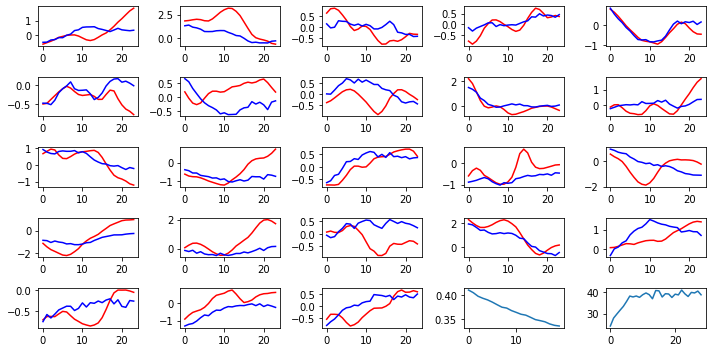

Step: 0, Train Loss: 0.35122227668762207
Step: 20, Train Loss: 0.2680245041847229
Step: 40, Train Loss: 0.36061128973960876
Step: 60, Train Loss: 0.3878948390483856
Step: 80, Train Loss: 0.2456800937652588
Step: 100, Train Loss: 0.3696931302547455
Step: 120, Train Loss: 0.32224002480506897
Step: 140, Train Loss: 0.3843410909175873
Epoch: 30, Train loss: 0.3329037024526839
acskill_socre:55.571869838208684, rmse_score:14.971242132752998
Epoch: 30, Valid Score: 40.600627705455686


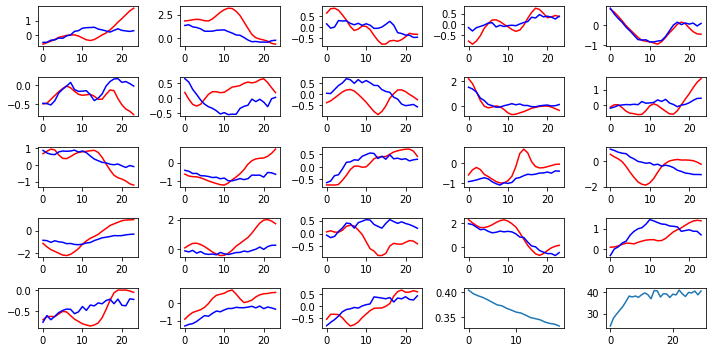

Step: 0, Train Loss: 0.32174813747406006
Step: 20, Train Loss: 0.33122146129608154
Step: 40, Train Loss: 0.30590787529945374
Step: 60, Train Loss: 0.3678348660469055
Step: 80, Train Loss: 0.375971257686615
Step: 100, Train Loss: 0.30701690912246704
Step: 120, Train Loss: 0.3643975257873535
Step: 140, Train Loss: 0.4141474664211273
Epoch: 31, Train loss: 0.33054874552662966
acskill_socre:55.31190227257023, rmse_score:15.018466114639953
Epoch: 31, Valid Score: 40.29343615793027


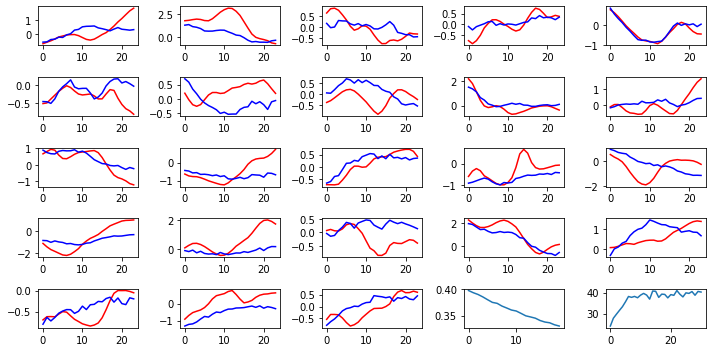

Step: 0, Train Loss: 0.30681490898132324
Step: 20, Train Loss: 0.30172789096832275
Step: 40, Train Loss: 0.2571849822998047
Step: 60, Train Loss: 0.40993794798851013
Step: 80, Train Loss: 0.27391618490219116
Step: 100, Train Loss: 0.4658995568752289
Step: 120, Train Loss: 0.2890588641166687
Step: 140, Train Loss: 0.45223674178123474
Epoch: 32, Train loss: 0.3273641289609253
acskill_socre:54.35788997170883, rmse_score:15.135309775579175
Epoch: 32, Valid Score: 39.222580196129655


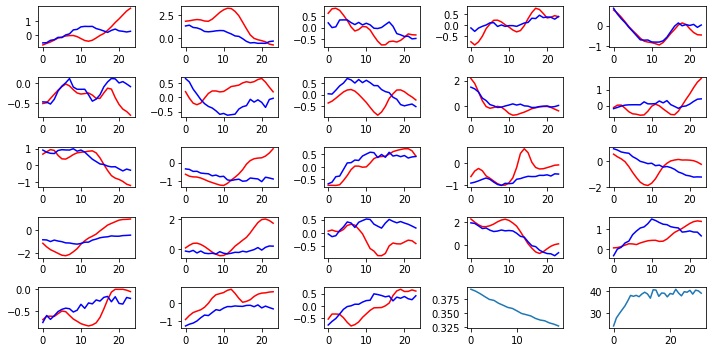

Step: 0, Train Loss: 0.24666404724121094
Step: 20, Train Loss: 0.3380974233150482
Step: 40, Train Loss: 0.40293002128601074
Step: 60, Train Loss: 0.40029284358024597
Step: 80, Train Loss: 0.23228637874126434
Step: 100, Train Loss: 0.25911223888397217
Step: 120, Train Loss: 0.19564513862133026
Step: 140, Train Loss: 0.3168495297431946
Epoch: 33, Train loss: 0.32460197104010613
acskill_socre:55.74910496392912, rmse_score:15.060317655025734
Epoch: 33, Valid Score: 40.688787308903386


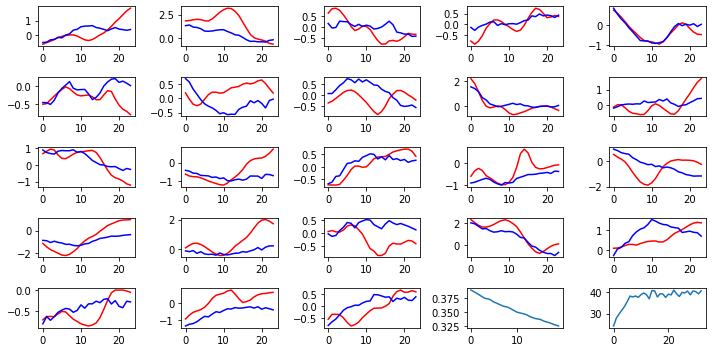

Step: 0, Train Loss: 0.46066349744796753
Step: 20, Train Loss: 0.25722479820251465
Step: 40, Train Loss: 0.22802457213401794
Step: 60, Train Loss: 0.28476572036743164
Step: 80, Train Loss: 0.3057805895805359
Step: 100, Train Loss: 0.314107209444046
Step: 120, Train Loss: 0.3278447985649109
Step: 140, Train Loss: 0.3707636296749115
Epoch: 34, Train loss: 0.32175571609074904
acskill_socre:55.2428907446414, rmse_score:15.031073387614873
Epoch: 34, Valid Score: 40.211817357026526


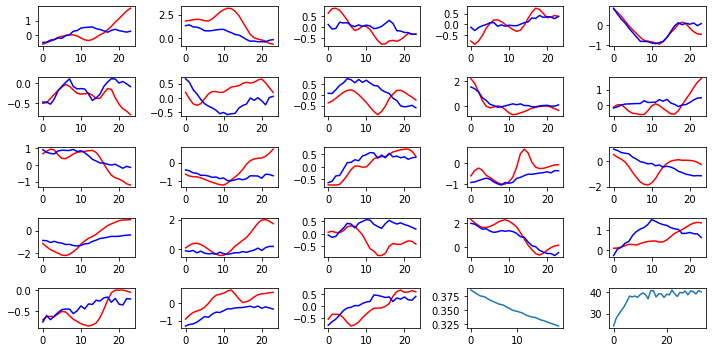

Step: 0, Train Loss: 0.3038226366043091
Step: 20, Train Loss: 0.3298916220664978
Step: 40, Train Loss: 0.2937227189540863
Step: 60, Train Loss: 0.30603930354118347
Step: 80, Train Loss: 0.2692084014415741
Step: 100, Train Loss: 0.27334076166152954
Step: 120, Train Loss: 0.299686998128891
Step: 140, Train Loss: 0.37869518995285034
Epoch: 35, Train loss: 0.32153339589097696
acskill_socre:55.04402481978593, rmse_score:15.10277741053103
Epoch: 35, Valid Score: 39.9412474092549


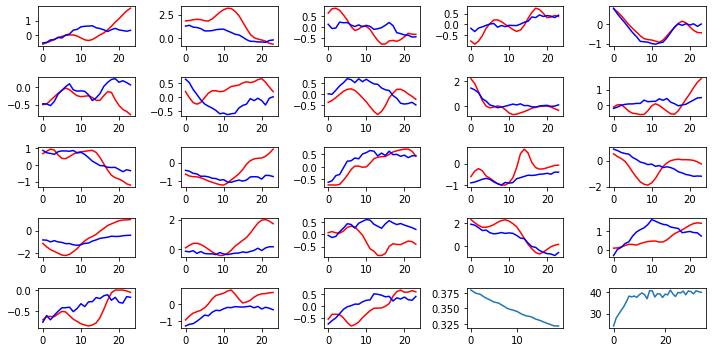

Step: 0, Train Loss: 0.2616273760795593
Step: 20, Train Loss: 0.2655333876609802
Step: 40, Train Loss: 0.362704873085022
Step: 60, Train Loss: 0.3120226263999939
Step: 80, Train Loss: 0.25295162200927734
Step: 100, Train Loss: 0.27345603704452515
Step: 120, Train Loss: 0.3098941743373871
Step: 140, Train Loss: 0.34093397855758667
Epoch: 36, Train loss: 0.31784126826911974
acskill_socre:55.25063419500808, rmse_score:15.08713407661435
Epoch: 36, Valid Score: 40.163500118393735


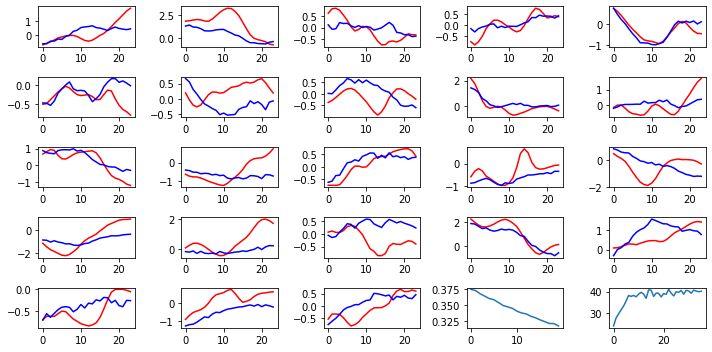

Step: 0, Train Loss: 0.27637043595314026
Step: 20, Train Loss: 0.32194846868515015
Step: 40, Train Loss: 0.30425822734832764
Step: 60, Train Loss: 0.24587099254131317
Step: 80, Train Loss: 0.3353935182094574
Step: 100, Train Loss: 0.30366846919059753
Step: 120, Train Loss: 0.28562629222869873
Step: 140, Train Loss: 0.34244880080223083
Epoch: 37, Train loss: 0.31653779773575486
acskill_socre:55.29337350540522, rmse_score:15.093086674970893
Epoch: 37, Valid Score: 40.20028683043433


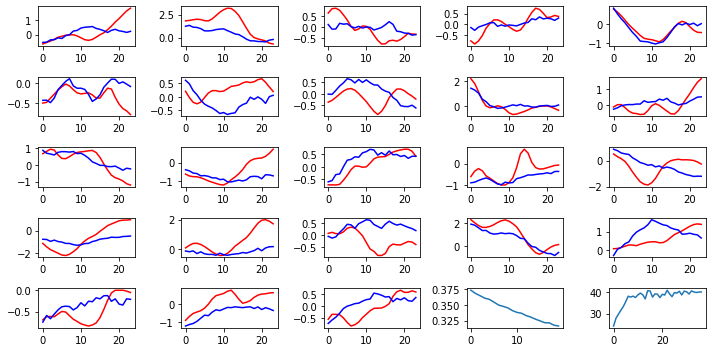

Step: 0, Train Loss: 0.22873932123184204
Step: 20, Train Loss: 0.2518303394317627
Step: 40, Train Loss: 0.3738402724266052
Step: 60, Train Loss: 0.27338045835494995
Step: 80, Train Loss: 0.4325975179672241
Step: 100, Train Loss: 0.3160177171230316
Step: 120, Train Loss: 0.2933444678783417
Step: 140, Train Loss: 0.33693405985832214
Epoch: 38, Train loss: 0.31506524562456045
acskill_socre:53.57638234694887, rmse_score:15.201185225224592
Epoch: 38, Valid Score: 38.37519712172428


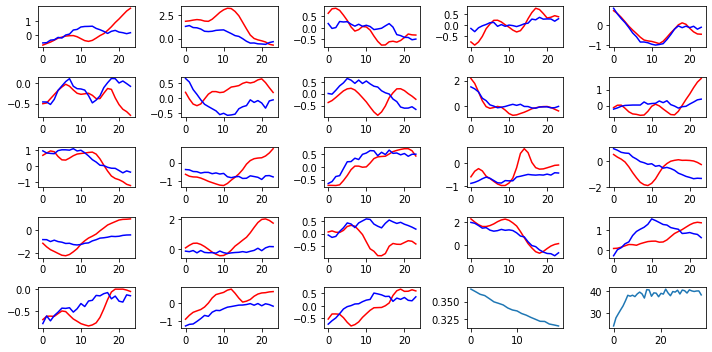

Step: 0, Train Loss: 0.3139517307281494
Step: 20, Train Loss: 0.2882843017578125
Step: 40, Train Loss: 0.3104126453399658
Step: 60, Train Loss: 0.3530840277671814
Step: 80, Train Loss: 0.2480444312095642
Step: 100, Train Loss: 0.4327845275402069
Step: 120, Train Loss: 0.2755967974662781
Step: 140, Train Loss: 0.24147868156433105
Epoch: 39, Train loss: 0.3098292085964968
acskill_socre:54.905496356065704, rmse_score:15.106895510366343
Epoch: 39, Valid Score: 39.79860084569936


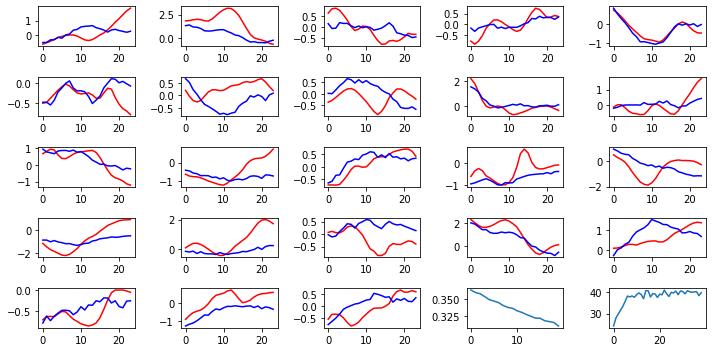

Step: 0, Train Loss: 0.27479788661003113
Step: 20, Train Loss: 0.3140319585800171
Step: 40, Train Loss: 0.2204025834798813
Step: 60, Train Loss: 0.30212053656578064
Step: 80, Train Loss: 0.3399035334587097
Step: 100, Train Loss: 0.3051393926143646
Step: 120, Train Loss: 0.3225431442260742
Step: 140, Train Loss: 0.24032601714134216
Epoch: 40, Train loss: 0.3076205879070197
acskill_socre:56.294293720835796, rmse_score:14.974725400536625
Epoch: 40, Valid Score: 41.31956832029917
Model saved successfully


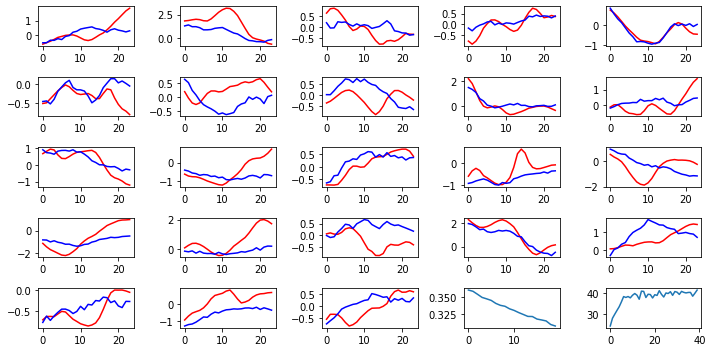

Step: 0, Train Loss: 0.23236070573329926
Step: 20, Train Loss: 0.29528388381004333
Step: 40, Train Loss: 0.2821885049343109
Step: 60, Train Loss: 0.22030293941497803
Step: 80, Train Loss: 0.28334566950798035
Step: 100, Train Loss: 0.27356573939323425
Step: 120, Train Loss: 0.3345063626766205
Step: 140, Train Loss: 0.3338436484336853
Epoch: 41, Train loss: 0.304974336627942
acskill_socre:54.275525427187816, rmse_score:15.240375166917339
Epoch: 41, Valid Score: 39.03515026027048


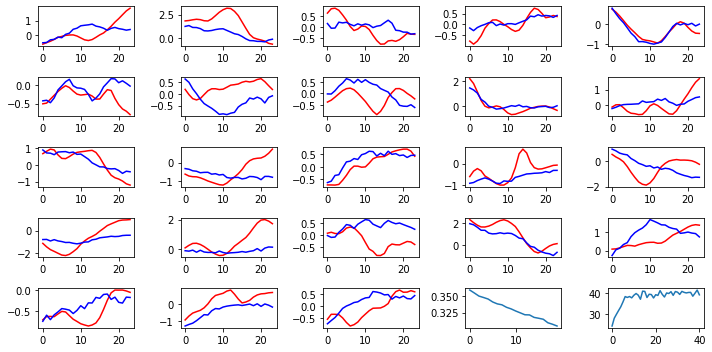

Step: 0, Train Loss: 0.3301553428173065
Step: 20, Train Loss: 0.32933318614959717
Step: 40, Train Loss: 0.2172875702381134
Step: 60, Train Loss: 0.21550032496452332
Step: 80, Train Loss: 0.31363603472709656
Step: 100, Train Loss: 0.18084082007408142
Step: 120, Train Loss: 0.3661632239818573
Step: 140, Train Loss: 0.3730623424053192
Epoch: 42, Train loss: 0.3041357187328825
acskill_socre:54.559425104851165, rmse_score:15.128151726344218
Epoch: 42, Valid Score: 39.431273378506944


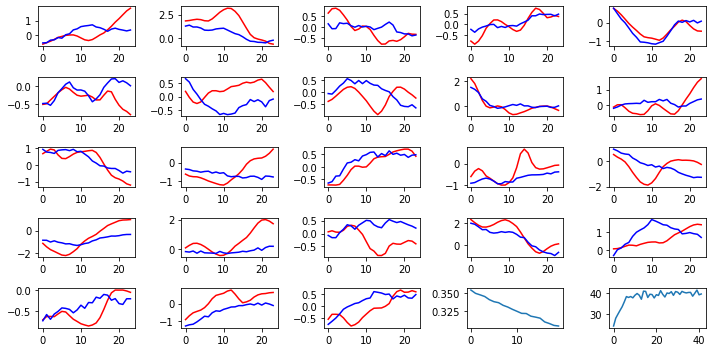

Step: 0, Train Loss: 0.32225197553634644
Step: 20, Train Loss: 0.3173298239707947
Step: 40, Train Loss: 0.3905307650566101
Step: 60, Train Loss: 0.3410831689834595
Step: 80, Train Loss: 0.3201260566711426
Step: 100, Train Loss: 0.3960689902305603
Step: 120, Train Loss: 0.2514236867427826
Step: 140, Train Loss: 0.4056926965713501
Epoch: 43, Train loss: 0.30284828137440284
acskill_socre:54.80984029500888, rmse_score:15.071053272626706
Epoch: 43, Valid Score: 39.738787022382176


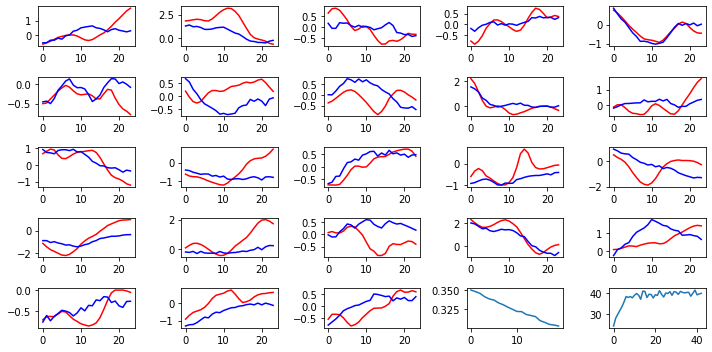

Step: 0, Train Loss: 0.23924192786216736
Step: 20, Train Loss: 0.24561284482479095
Step: 40, Train Loss: 0.2596943974494934
Step: 60, Train Loss: 0.29755473136901855
Step: 80, Train Loss: 0.26439106464385986
Step: 100, Train Loss: 0.34618985652923584
Step: 120, Train Loss: 0.28630444407463074
Step: 140, Train Loss: 0.31943896412849426
Epoch: 44, Train loss: 0.2996356770111497
acskill_socre:54.89122301923932, rmse_score:15.225226597206786
Epoch: 44, Valid Score: 39.665996422032535


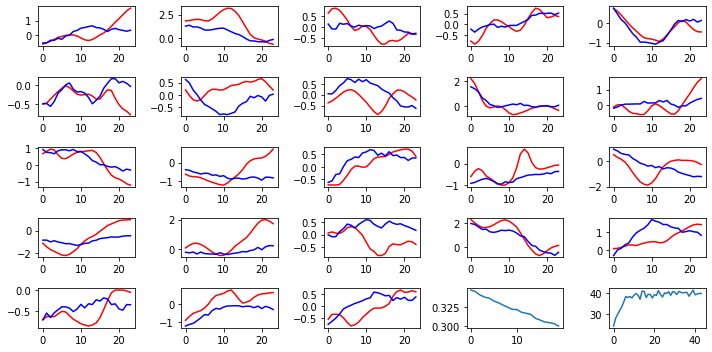

Step: 0, Train Loss: 0.25695836544036865
Step: 20, Train Loss: 0.335733026266098
Step: 40, Train Loss: 0.33773231506347656
Step: 60, Train Loss: 0.2586088180541992
Step: 80, Train Loss: 0.33632636070251465
Step: 100, Train Loss: 0.25958746671676636
Step: 120, Train Loss: 0.29340603947639465
Step: 140, Train Loss: 0.20547661185264587
Epoch: 45, Train loss: 0.2963082366118765
acskill_socre:54.33709885110821, rmse_score:15.220998204698112
Epoch: 45, Valid Score: 39.116100646410096


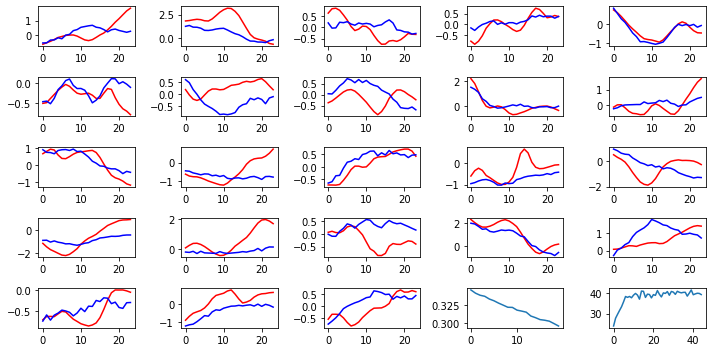

Step: 0, Train Loss: 0.3513067662715912
Step: 20, Train Loss: 0.4151690900325775
Step: 40, Train Loss: 0.3061850666999817
Step: 60, Train Loss: 0.2791886031627655
Step: 80, Train Loss: 0.29930806159973145
Step: 100, Train Loss: 0.23673920333385468
Step: 120, Train Loss: 0.22441253066062927
Step: 140, Train Loss: 0.26140254735946655
Epoch: 46, Train loss: 0.29407328595021726
acskill_socre:54.12179454520087, rmse_score:15.219562189610587
Epoch: 46, Valid Score: 38.902232355590286


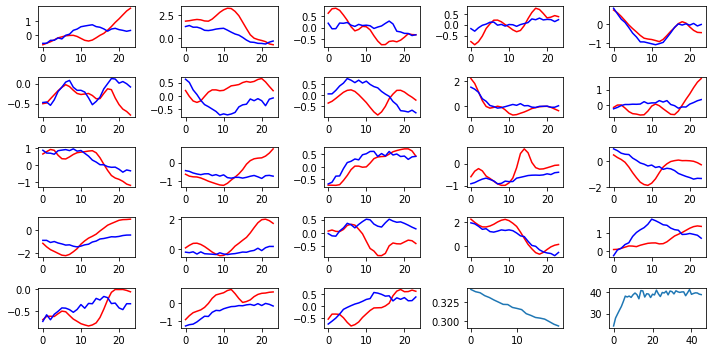

Step: 0, Train Loss: 0.3975237011909485
Step: 20, Train Loss: 0.29842281341552734
Step: 40, Train Loss: 0.25163066387176514
Step: 60, Train Loss: 0.25147491693496704
Step: 80, Train Loss: 0.24121126532554626
Step: 100, Train Loss: 0.3265094459056854
Step: 120, Train Loss: 0.2457028031349182
Step: 140, Train Loss: 0.37335047125816345
Epoch: 47, Train loss: 0.29029298018498023
acskill_socre:53.27915721210472, rmse_score:15.189305278033647
Epoch: 47, Valid Score: 38.08985193407108


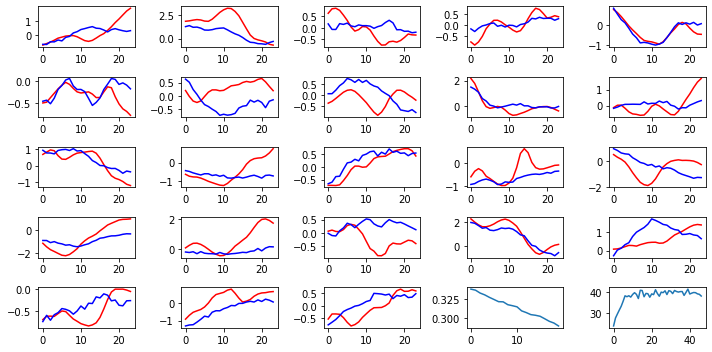

Step: 0, Train Loss: 0.3078065812587738
Step: 20, Train Loss: 0.3721165060997009
Step: 40, Train Loss: 0.3540913462638855
Step: 60, Train Loss: 0.26539766788482666
Step: 80, Train Loss: 0.24670162796974182
Step: 100, Train Loss: 0.19550681114196777
Step: 120, Train Loss: 0.2856733798980713
Step: 140, Train Loss: 0.2576870620250702
Epoch: 48, Train loss: 0.2889779166431184
acskill_socre:55.203851516855266, rmse_score:15.227894591649491
Epoch: 48, Valid Score: 39.97595692520578


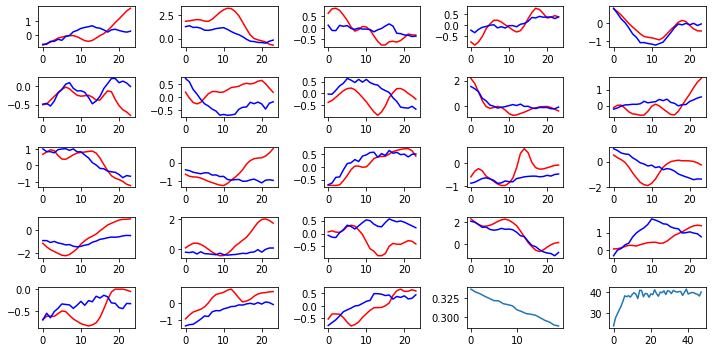

Step: 0, Train Loss: 0.3143162727355957
Step: 20, Train Loss: 0.32499074935913086
Step: 40, Train Loss: 0.2702978253364563
Step: 60, Train Loss: 0.25665533542633057
Step: 80, Train Loss: 0.3353869318962097
Step: 100, Train Loss: 0.34576138854026794
Step: 120, Train Loss: 0.2702053487300873
Step: 140, Train Loss: 0.3282455801963806
Epoch: 49, Train loss: 0.28672162932195483
acskill_socre:53.696334715639814, rmse_score:15.262867652836597
Epoch: 49, Valid Score: 38.43346706280322


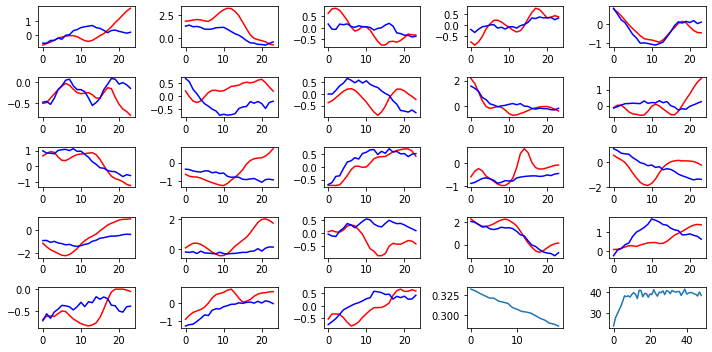

Step: 0, Train Loss: 0.21945396065711975
Step: 20, Train Loss: 0.2725728154182434
Step: 40, Train Loss: 0.3075963258743286
Step: 60, Train Loss: 0.28273484110832214
Step: 80, Train Loss: 0.23197923600673676
Step: 100, Train Loss: 0.255815327167511
Step: 120, Train Loss: 0.4034862518310547
Step: 140, Train Loss: 0.32547447085380554
Epoch: 50, Train loss: 0.2852632883627703
acskill_socre:54.72663580844009, rmse_score:15.303484808530486
Epoch: 50, Valid Score: 39.42315099990961


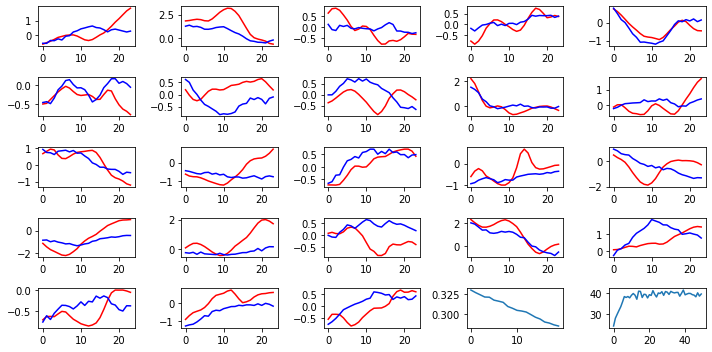

Step: 0, Train Loss: 0.24973897635936737
Step: 20, Train Loss: 0.2864930331707001
Step: 40, Train Loss: 0.2897701561450958
Step: 60, Train Loss: 0.3277134299278259
Step: 80, Train Loss: 0.3438563346862793
Step: 100, Train Loss: 0.29228639602661133
Step: 120, Train Loss: 0.28563255071640015
Step: 140, Train Loss: 0.3050553798675537
Epoch: 51, Train loss: 0.2840655382461609
acskill_socre:53.9847503142444, rmse_score:15.254651324057283
Epoch: 51, Valid Score: 38.730098990187116


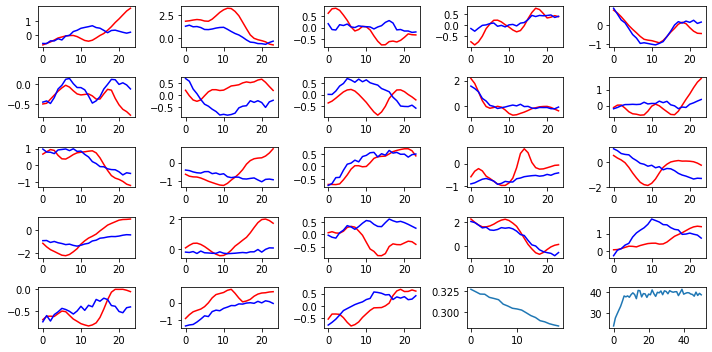

Step: 0, Train Loss: 0.31310269236564636
Step: 20, Train Loss: 0.29070279002189636
Step: 40, Train Loss: 0.23412196338176727
Step: 60, Train Loss: 0.2665819823741913
Step: 80, Train Loss: 0.32804903388023376
Step: 100, Train Loss: 0.41734981536865234
Step: 120, Train Loss: 0.2978527545928955
Step: 140, Train Loss: 0.42075115442276
Epoch: 52, Train loss: 0.2821186090920382
acskill_socre:53.15119256742836, rmse_score:15.334791726003905
Epoch: 52, Valid Score: 37.81640084142445


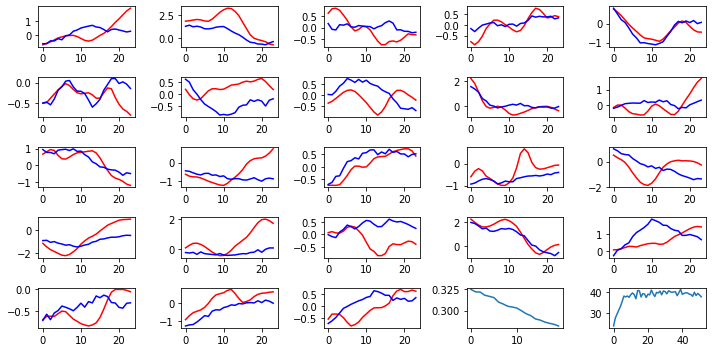

Step: 0, Train Loss: 0.2698560059070587
Step: 20, Train Loss: 0.24462637305259705
Step: 40, Train Loss: 0.27710771560668945
Step: 60, Train Loss: 0.2697857618331909
Step: 80, Train Loss: 0.21930435299873352
Step: 100, Train Loss: 0.29784440994262695
Step: 120, Train Loss: 0.3191732168197632
Step: 140, Train Loss: 0.34771740436553955
Epoch: 53, Train loss: 0.2782905093234056
acskill_socre:53.93020808932546, rmse_score:15.300472218184243
Epoch: 53, Valid Score: 38.62973587114122


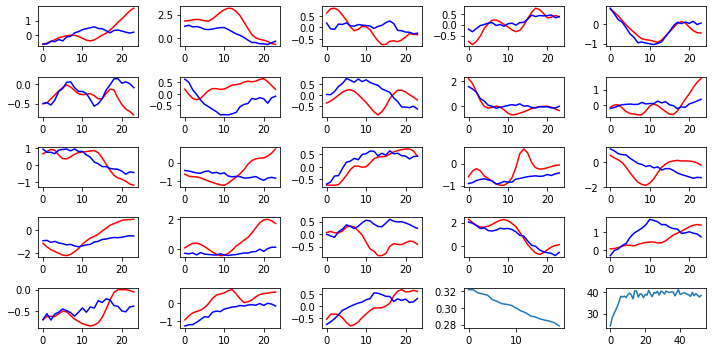

Step: 0, Train Loss: 0.27587756514549255
Step: 20, Train Loss: 0.2937657833099365
Step: 40, Train Loss: 0.25049731135368347
Step: 60, Train Loss: 0.2241843342781067
Step: 80, Train Loss: 0.2924593389034271
Step: 100, Train Loss: 0.2270732820034027
Step: 120, Train Loss: 0.3252161741256714
Step: 140, Train Loss: 0.32876914739608765
Epoch: 54, Train loss: 0.27804396505568435
acskill_socre:54.34643555692681, rmse_score:15.274011884130514
Epoch: 54, Valid Score: 39.07242367279629


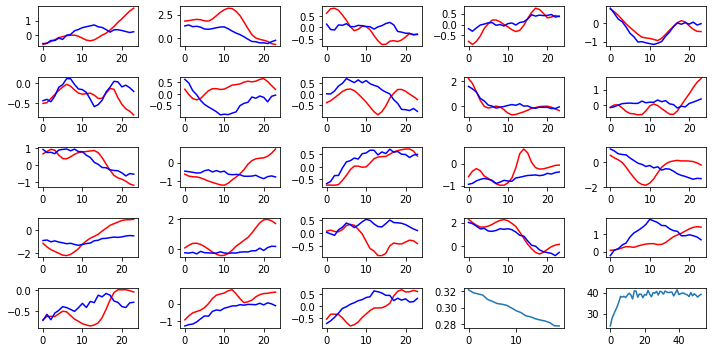

Step: 0, Train Loss: 0.24307870864868164
Step: 20, Train Loss: 0.2145703136920929
Step: 40, Train Loss: 0.23025161027908325
Step: 60, Train Loss: 0.20014825463294983
Step: 80, Train Loss: 0.27760452032089233
Step: 100, Train Loss: 0.2530992031097412
Step: 120, Train Loss: 0.30536872148513794
Step: 140, Train Loss: 0.18776941299438477
Epoch: 55, Train loss: 0.27353120865715536
acskill_socre:54.40292507828992, rmse_score:15.25307649985981
Epoch: 55, Valid Score: 39.14984857843011


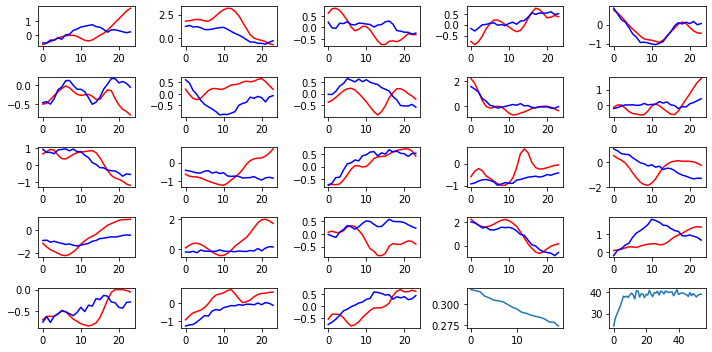

Step: 0, Train Loss: 0.26897990703582764
Step: 20, Train Loss: 0.22192099690437317
Step: 40, Train Loss: 0.23529300093650818
Step: 60, Train Loss: 0.3992301821708679
Step: 80, Train Loss: 0.38290199637413025
Step: 100, Train Loss: 0.3807692527770996
Step: 120, Train Loss: 0.2574388384819031
Step: 140, Train Loss: 0.3453807234764099
Epoch: 56, Train loss: 0.2714796453524547
acskill_socre:54.1989117025467, rmse_score:15.340016874211912
Epoch: 56, Valid Score: 38.85889482833479


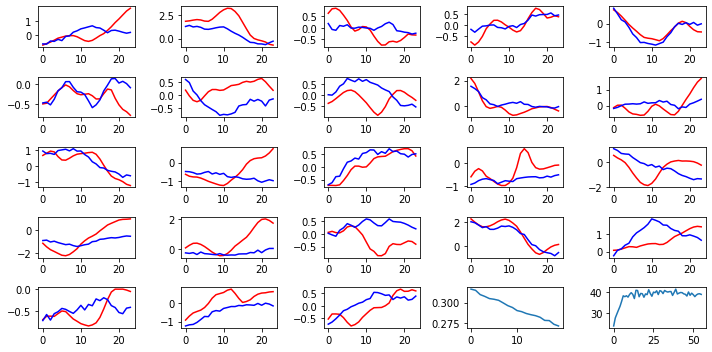

Step: 0, Train Loss: 0.30748385190963745
Step: 20, Train Loss: 0.2771342992782593
Step: 40, Train Loss: 0.25588259100914
Step: 60, Train Loss: 0.2486685961484909
Step: 80, Train Loss: 0.3201925456523895
Step: 100, Train Loss: 0.24611607193946838
Step: 120, Train Loss: 0.3164541721343994
Step: 140, Train Loss: 0.2819117307662964
Epoch: 57, Train loss: 0.2690663800877371
acskill_socre:55.387783193033314, rmse_score:15.184598942492883
Epoch: 57, Valid Score: 40.20318425054043


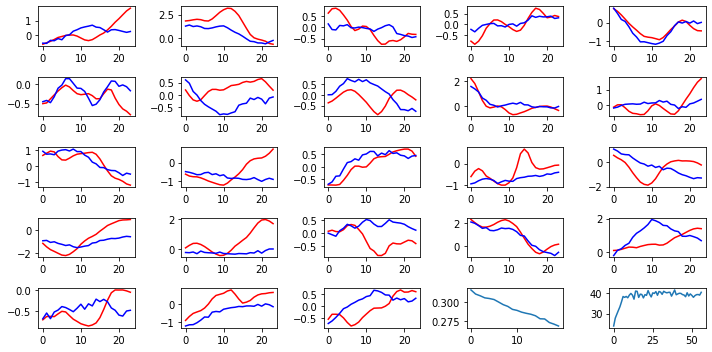

Step: 0, Train Loss: 0.18251383304595947
Step: 20, Train Loss: 0.27649959921836853
Step: 40, Train Loss: 0.24375443160533905
Step: 60, Train Loss: 0.17879192531108856
Step: 80, Train Loss: 0.2879176139831543
Step: 100, Train Loss: 0.27634888887405396
Step: 120, Train Loss: 0.20432917773723602
Step: 140, Train Loss: 0.3333863914012909
Epoch: 58, Train loss: 0.26742960132990673
acskill_socre:54.197255833666475, rmse_score:15.314434994122564
Epoch: 58, Valid Score: 38.88282083954391


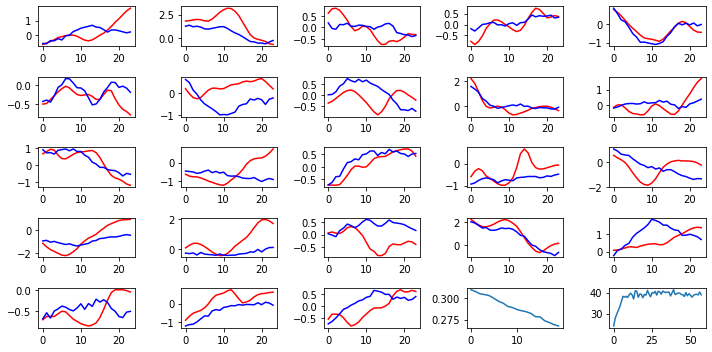

Step: 0, Train Loss: 0.1927289366722107
Step: 20, Train Loss: 0.2880864143371582
Step: 40, Train Loss: 0.1920248568058014
Step: 60, Train Loss: 0.27707579731941223
Step: 80, Train Loss: 0.34350043535232544
Step: 100, Train Loss: 0.27209192514419556
Step: 120, Train Loss: 0.3555227220058441
Step: 140, Train Loss: 0.22231408953666687
Epoch: 59, Train loss: 0.264429345632055
acskill_socre:53.79721513705036, rmse_score:15.27976991715342
Epoch: 59, Valid Score: 38.51744521989694


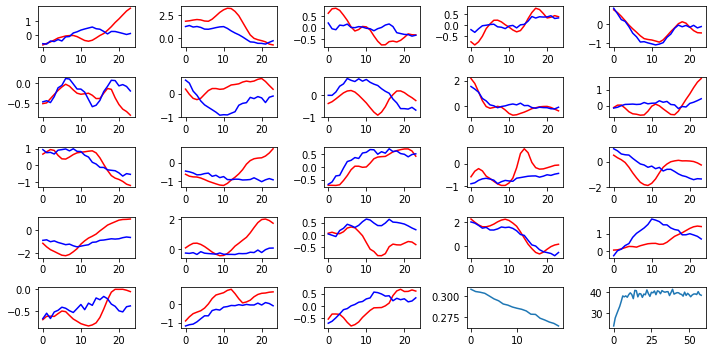

Step: 0, Train Loss: 0.19547832012176514
Step: 20, Train Loss: 0.22990523278713226
Step: 40, Train Loss: 0.25925517082214355
Step: 60, Train Loss: 0.21811965107917786
Step: 80, Train Loss: 0.24710910022258759
Step: 100, Train Loss: 0.2882702946662903
Step: 120, Train Loss: 0.23655371367931366
Step: 140, Train Loss: 0.2253739833831787
Epoch: 60, Train loss: 0.26128316357447084
acskill_socre:52.97094231461641, rmse_score:15.381952068027234
Epoch: 60, Valid Score: 37.58899024658918


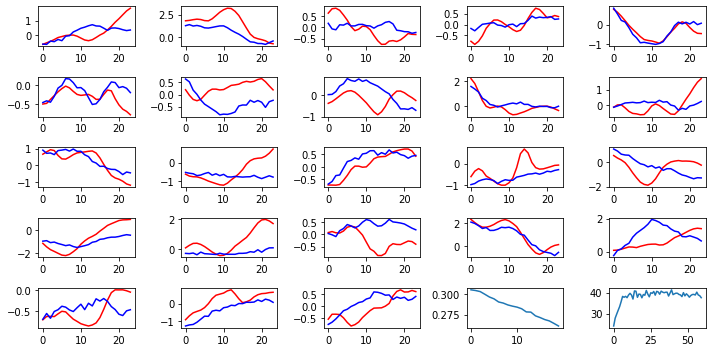

Step: 0, Train Loss: 0.24443469941616058
Step: 20, Train Loss: 0.3713070750236511
Step: 40, Train Loss: 0.3045217990875244
Step: 60, Train Loss: 0.30951792001724243
Step: 80, Train Loss: 0.2532327175140381
Step: 100, Train Loss: 0.28109103441238403
Step: 120, Train Loss: 0.29822617769241333
Step: 140, Train Loss: 0.263990581035614
Epoch: 61, Train loss: 0.25975075867145686
acskill_socre:55.07626519768841, rmse_score:15.269551780128385
Epoch: 61, Valid Score: 39.80671341756002


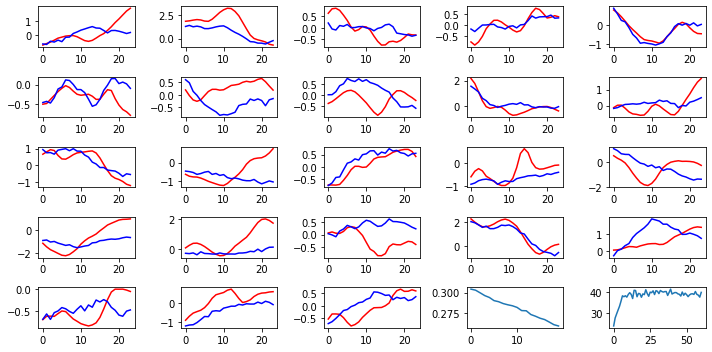

Step: 0, Train Loss: 0.20731472969055176
Step: 20, Train Loss: 0.3071169853210449
Step: 40, Train Loss: 0.2124374359846115
Step: 60, Train Loss: 0.26006895303726196
Step: 80, Train Loss: 0.26506710052490234
Step: 100, Train Loss: 0.22093608975410461
Step: 120, Train Loss: 0.26851603388786316
Step: 140, Train Loss: 0.23754718899726868
Epoch: 62, Train loss: 0.25685194495377267
acskill_socre:55.237653857505514, rmse_score:15.207284616919964
Epoch: 62, Valid Score: 40.03036924058555


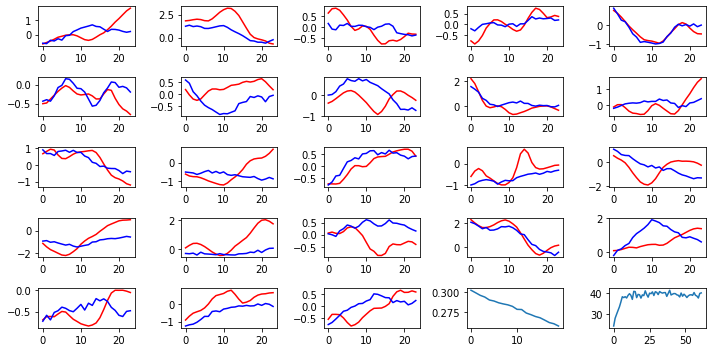

Step: 0, Train Loss: 0.26315993070602417
Step: 20, Train Loss: 0.23724114894866943
Step: 40, Train Loss: 0.36281222105026245
Step: 60, Train Loss: 0.29835450649261475
Step: 80, Train Loss: 0.2451396882534027
Step: 100, Train Loss: 0.27534884214401245
Step: 120, Train Loss: 0.18367189168930054
Step: 140, Train Loss: 0.3297556936740875
Epoch: 63, Train loss: 0.25769523801697286
acskill_socre:53.079278310703444, rmse_score:15.410252210328684
Epoch: 63, Valid Score: 37.66902610037476


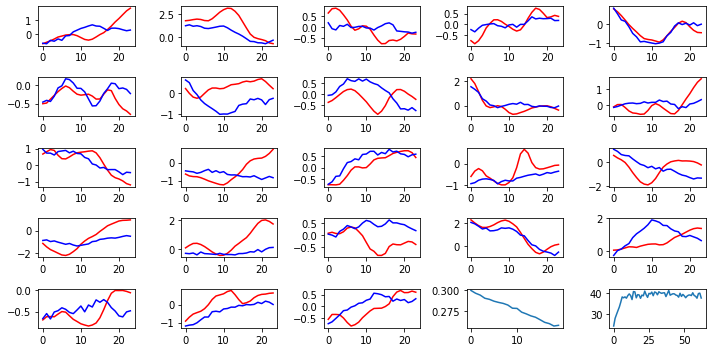

Step: 0, Train Loss: 0.26975733041763306
Step: 20, Train Loss: 0.36205005645751953
Step: 40, Train Loss: 0.2700806260108948
Step: 60, Train Loss: 0.22700545191764832
Step: 80, Train Loss: 0.2906576991081238
Step: 100, Train Loss: 0.24407526850700378
Step: 120, Train Loss: 0.30185267329216003
Step: 140, Train Loss: 0.24992090463638306
Epoch: 64, Train loss: 0.25368307682738944
acskill_socre:52.373706664271054, rmse_score:15.560614530647467
Epoch: 64, Valid Score: 36.813092133623584


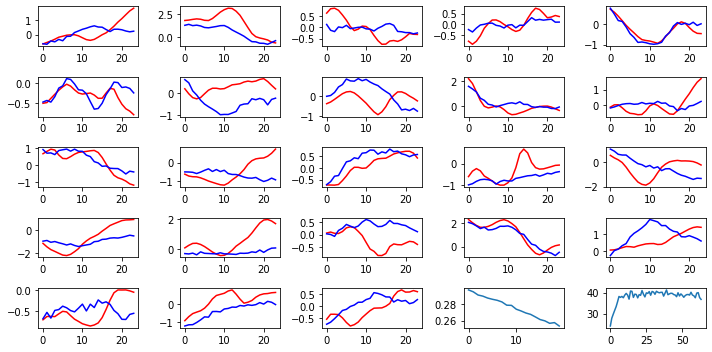

Step: 0, Train Loss: 0.18595990538597107
Step: 20, Train Loss: 0.2518913149833679
Step: 40, Train Loss: 0.2318221777677536
Step: 60, Train Loss: 0.33141469955444336
Step: 80, Train Loss: 0.2514302134513855
Step: 100, Train Loss: 0.2402612417936325
Step: 120, Train Loss: 0.2990858554840088
Step: 140, Train Loss: 0.3204616904258728
Epoch: 65, Train loss: 0.2519647759996402
acskill_socre:54.11870070565878, rmse_score:15.393920751299294
Epoch: 65, Valid Score: 38.72477995435949


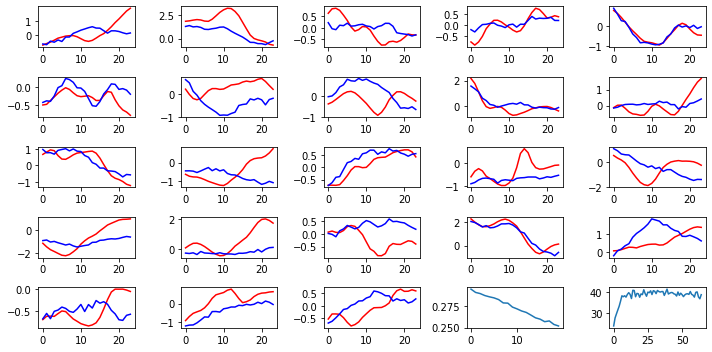

Step: 0, Train Loss: 0.24590834975242615
Step: 20, Train Loss: 0.3152247369289398
Step: 40, Train Loss: 0.2742791175842285
Step: 60, Train Loss: 0.2702082097530365
Step: 80, Train Loss: 0.2712874412536621
Step: 100, Train Loss: 0.2445530742406845
Step: 120, Train Loss: 0.3435140550136566
Step: 140, Train Loss: 0.15383264422416687
Epoch: 66, Train loss: 0.2496456352958254
acskill_socre:54.460607815588574, rmse_score:15.409737334447147
Epoch: 66, Valid Score: 39.05087048114143


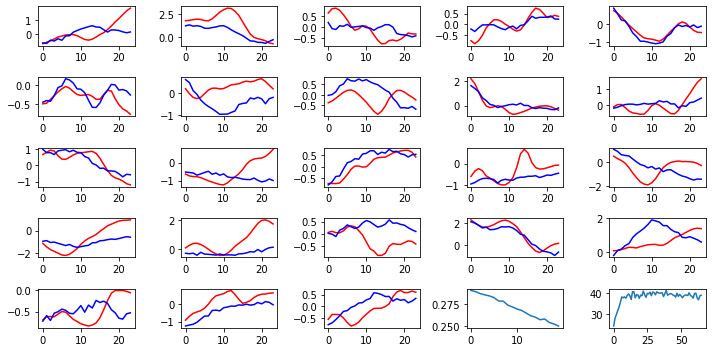

Step: 0, Train Loss: 0.23284316062927246
Step: 20, Train Loss: 0.2167639434337616
Step: 40, Train Loss: 0.22888100147247314
Step: 60, Train Loss: 0.2579500377178192
Step: 80, Train Loss: 0.2054920792579651
Step: 100, Train Loss: 0.2903728485107422
Step: 120, Train Loss: 0.2714026868343353
Step: 140, Train Loss: 0.20066355168819427
Epoch: 67, Train loss: 0.2462818053117983
acskill_socre:53.37980631281003, rmse_score:15.48800711290316
Epoch: 67, Valid Score: 37.89179919990687


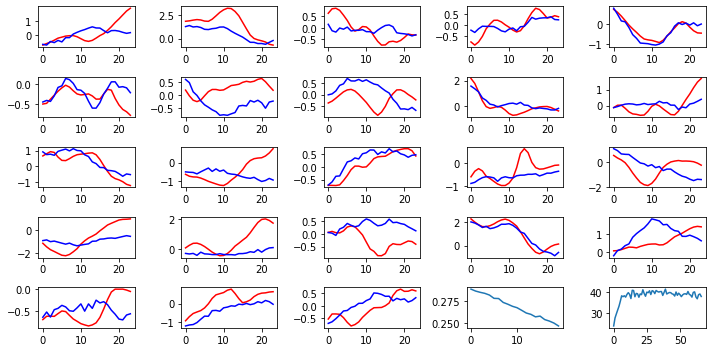

Step: 0, Train Loss: 0.2307182252407074
Step: 20, Train Loss: 0.1999116986989975
Step: 40, Train Loss: 0.20686183869838715
Step: 60, Train Loss: 0.2316199243068695
Step: 80, Train Loss: 0.33142921328544617
Step: 100, Train Loss: 0.24018876254558563
Step: 120, Train Loss: 0.19321076571941376
Step: 140, Train Loss: 0.15751206874847412
Epoch: 68, Train loss: 0.24310282233414376
acskill_socre:55.28832015095882, rmse_score:15.35650325022982
Epoch: 68, Valid Score: 39.931816900729


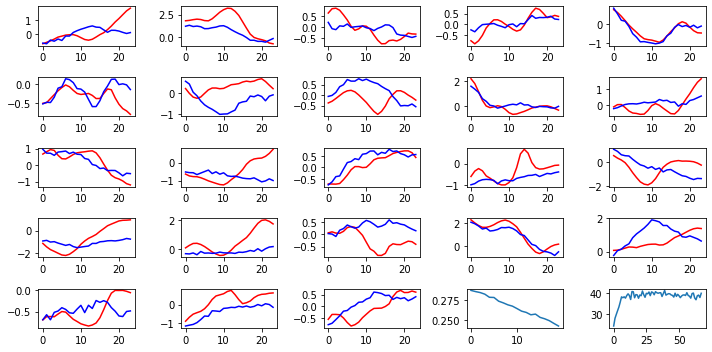

Step: 0, Train Loss: 0.3558647632598877
Step: 20, Train Loss: 0.22429120540618896
Step: 40, Train Loss: 0.26487982273101807
Step: 60, Train Loss: 0.2521386742591858
Step: 80, Train Loss: 0.2357529103755951
Step: 100, Train Loss: 0.2781493067741394
Step: 120, Train Loss: 0.33742353320121765
Step: 140, Train Loss: 0.30034223198890686
Epoch: 69, Train loss: 0.24061608081980115
acskill_socre:53.79251837207569, rmse_score:15.4815964284187
Epoch: 69, Valid Score: 38.31092194365699


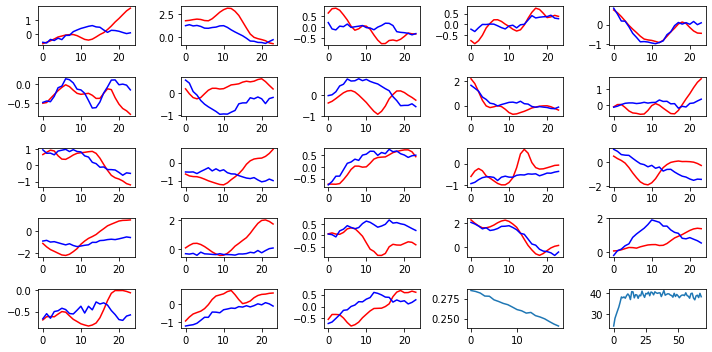

Step: 0, Train Loss: 0.2562183141708374
Step: 20, Train Loss: 0.23132291436195374
Step: 40, Train Loss: 0.246551975607872
Step: 60, Train Loss: 0.2869308590888977
Step: 80, Train Loss: 0.23451074957847595
Step: 100, Train Loss: 0.20715086162090302
Step: 120, Train Loss: 0.16443556547164917
Step: 140, Train Loss: 0.19224980473518372
Epoch: 70, Train loss: 0.23722610712810688
acskill_socre:53.59812841704924, rmse_score:15.538984385591414
Epoch: 70, Valid Score: 38.059144031457826


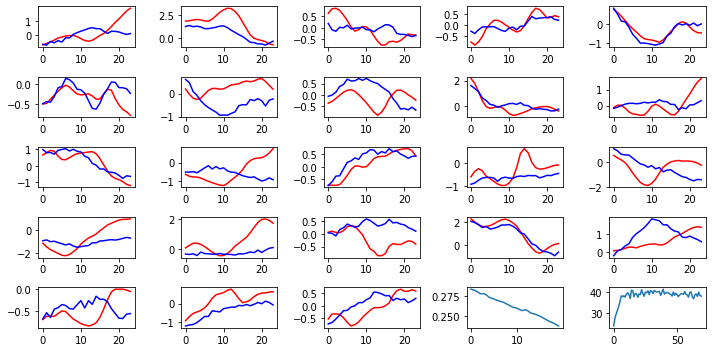

Step: 0, Train Loss: 0.2972106635570526
Step: 20, Train Loss: 0.2126176655292511
Step: 40, Train Loss: 0.20435234904289246
Step: 60, Train Loss: 0.25038230419158936
Step: 80, Train Loss: 0.19198554754257202
Step: 100, Train Loss: 0.24297812581062317
Step: 120, Train Loss: 0.23703110218048096
Step: 140, Train Loss: 0.2007085084915161
Epoch: 71, Train loss: 0.23772184844988925
acskill_socre:53.88901750481083, rmse_score:15.442253569160185
Epoch: 71, Valid Score: 38.446763935650644


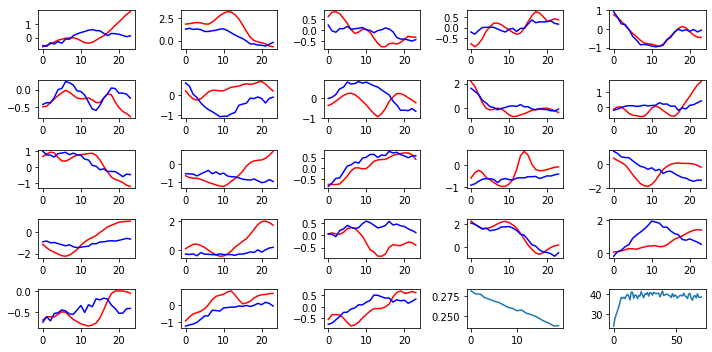

Step: 0, Train Loss: 0.18064133822917938
Step: 20, Train Loss: 0.23571652173995972
Step: 40, Train Loss: 0.26657477021217346
Step: 60, Train Loss: 0.24705180525779724
Step: 80, Train Loss: 0.24272561073303223
Step: 100, Train Loss: 0.22151391208171844
Step: 120, Train Loss: 0.19968323409557343
Step: 140, Train Loss: 0.206582173705101
Epoch: 72, Train loss: 0.23555130867441748
acskill_socre:54.62049950683511, rmse_score:15.453897309191015
Epoch: 72, Valid Score: 39.166602197644096


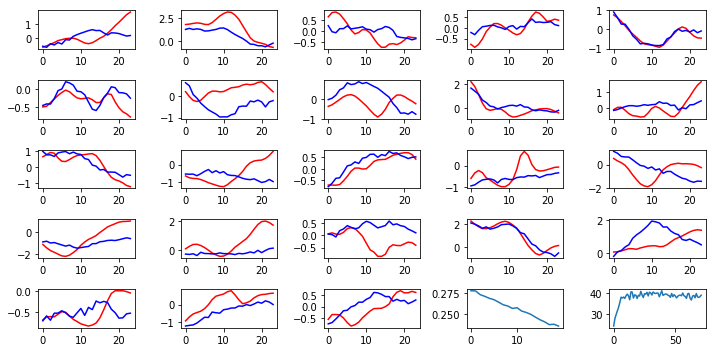

Step: 0, Train Loss: 0.2166292667388916
Step: 20, Train Loss: 0.1536361277103424
Step: 40, Train Loss: 0.2807287573814392
Step: 60, Train Loss: 0.20686648786067963
Step: 80, Train Loss: 0.2964904308319092
Step: 100, Train Loss: 0.297309935092926
Step: 120, Train Loss: 0.2447730302810669
Step: 140, Train Loss: 0.21341478824615479
Epoch: 73, Train loss: 0.23291588408552158
acskill_socre:54.213057067638374, rmse_score:15.46317629272966
Epoch: 73, Valid Score: 38.74988077490872


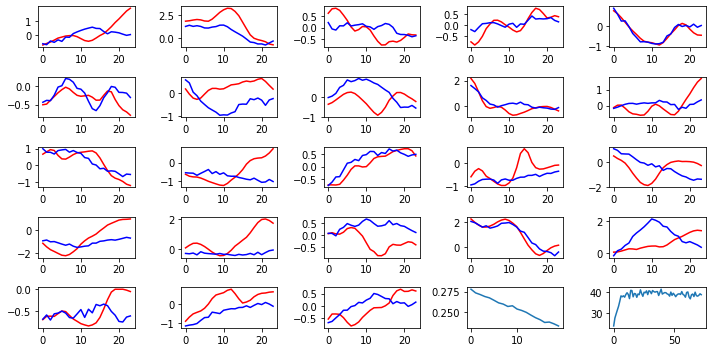

Step: 0, Train Loss: 0.21097783744335175
Step: 20, Train Loss: 0.22333097457885742
Step: 40, Train Loss: 0.23474818468093872
Step: 60, Train Loss: 0.3604053854942322
Step: 80, Train Loss: 0.32643193006515503
Step: 100, Train Loss: 0.21830222010612488
Step: 120, Train Loss: 0.22930626571178436
Step: 140, Train Loss: 0.2920251190662384
Epoch: 74, Train loss: 0.229000737997377
acskill_socre:51.84787243365983, rmse_score:15.705952340806958
Epoch: 74, Valid Score: 36.14192009285287


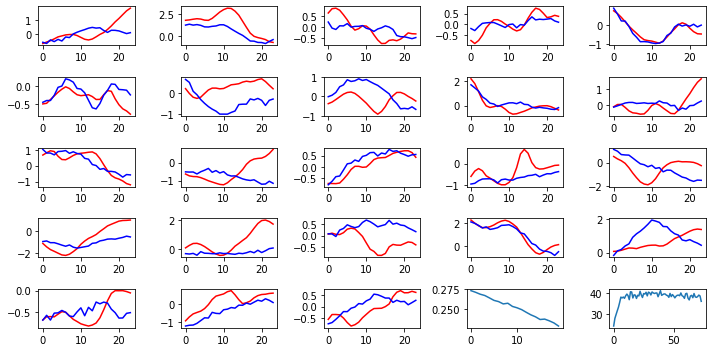

Step: 0, Train Loss: 0.3217197060585022
Step: 20, Train Loss: 0.19603493809700012
Step: 40, Train Loss: 0.27306807041168213
Step: 60, Train Loss: 0.26595303416252136
Step: 80, Train Loss: 0.20120446383953094
Step: 100, Train Loss: 0.23914524912834167
Step: 120, Train Loss: 0.22698894143104553
Step: 140, Train Loss: 0.2556438148021698
Epoch: 75, Train loss: 0.22708243928897154
acskill_socre:52.92395270005483, rmse_score:15.530212667056785
Epoch: 75, Valid Score: 37.393740032998046


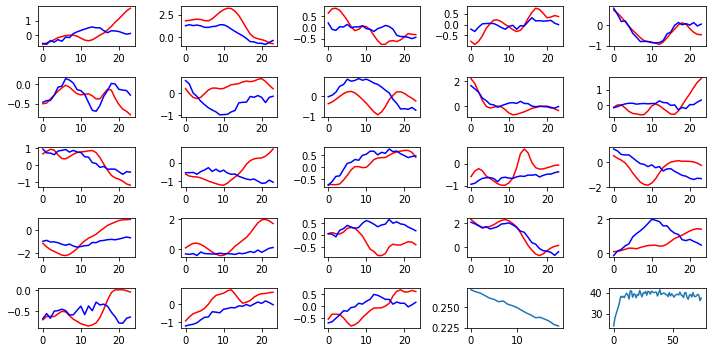

Step: 0, Train Loss: 0.19883188605308533
Step: 20, Train Loss: 0.2171921730041504
Step: 40, Train Loss: 0.22642019391059875
Step: 60, Train Loss: 0.1977856606245041
Step: 80, Train Loss: 0.2377862185239792
Step: 100, Train Loss: 0.20694562792778015
Step: 120, Train Loss: 0.17846564948558807
Step: 140, Train Loss: 0.2276601493358612
Epoch: 76, Train loss: 0.2246792426534519
acskill_socre:53.69018780092449, rmse_score:15.489095848416971
Epoch: 76, Valid Score: 38.20109195250752


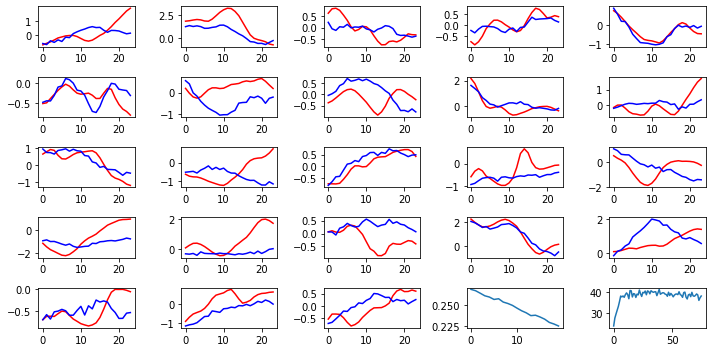

Step: 0, Train Loss: 0.21963998675346375
Step: 20, Train Loss: 0.2226821631193161
Step: 40, Train Loss: 0.2329520434141159
Step: 60, Train Loss: 0.2042149007320404
Step: 80, Train Loss: 0.18193873763084412
Step: 100, Train Loss: 0.2013627290725708
Step: 120, Train Loss: 0.20903627574443817
Step: 140, Train Loss: 0.17080871760845184
Epoch: 77, Train loss: 0.22280374776785541
acskill_socre:53.63052734093249, rmse_score:15.620624604727743
Epoch: 77, Valid Score: 38.009902736204744


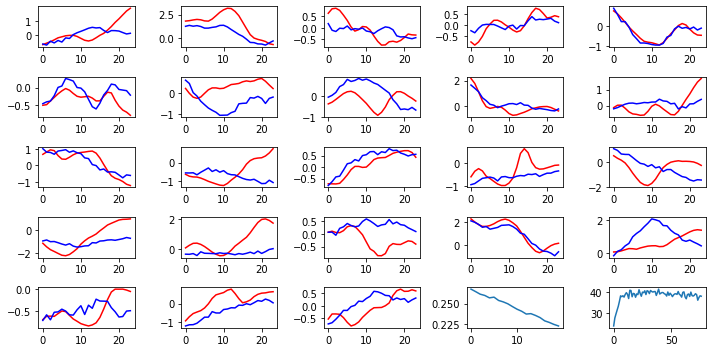

Step: 0, Train Loss: 0.1650511622428894
Step: 20, Train Loss: 0.15476736426353455
Step: 40, Train Loss: 0.20266184210777283
Step: 60, Train Loss: 0.21306709945201874
Step: 80, Train Loss: 0.23942336440086365
Step: 100, Train Loss: 0.24195000529289246
Step: 120, Train Loss: 0.2612457871437073
Step: 140, Train Loss: 0.21436485648155212
Epoch: 78, Train loss: 0.21951114481231968
acskill_socre:54.52881571461283, rmse_score:15.534543750182134
Epoch: 78, Valid Score: 38.994271964430695


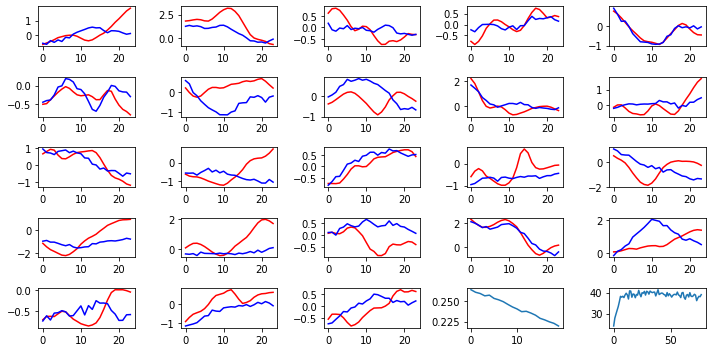

Step: 0, Train Loss: 0.20942184329032898
Step: 20, Train Loss: 0.19826331734657288
Step: 40, Train Loss: 0.21678553521633148
Step: 60, Train Loss: 0.3280123770236969
Step: 80, Train Loss: 0.23042011260986328
Step: 100, Train Loss: 0.2898576855659485
Step: 120, Train Loss: 0.22688034176826477
Step: 140, Train Loss: 0.20049886405467987
Epoch: 79, Train loss: 0.21849502319363273
acskill_socre:54.47698133810259, rmse_score:15.564159986747795
Epoch: 79, Valid Score: 38.91282135135479


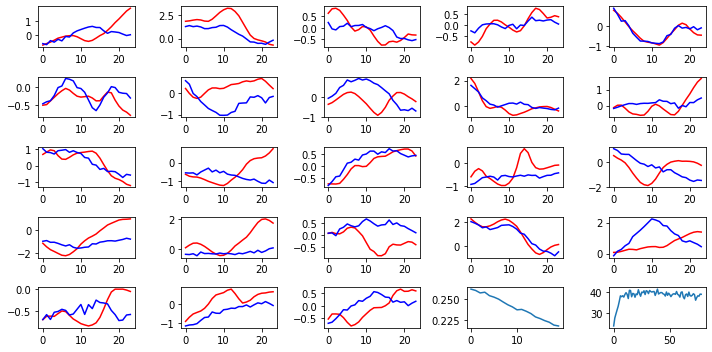

Step: 0, Train Loss: 0.27659106254577637
Step: 20, Train Loss: 0.15761271119117737
Step: 40, Train Loss: 0.20336109399795532
Step: 60, Train Loss: 0.20796482264995575
Step: 80, Train Loss: 0.2025957703590393
Step: 100, Train Loss: 0.18509718775749207
Step: 120, Train Loss: 0.23968927562236786
Step: 140, Train Loss: 0.2046547383069992
Epoch: 80, Train loss: 0.21512197736342242
acskill_socre:53.243376927017195, rmse_score:15.722177035375628
Epoch: 80, Valid Score: 37.521199891641565


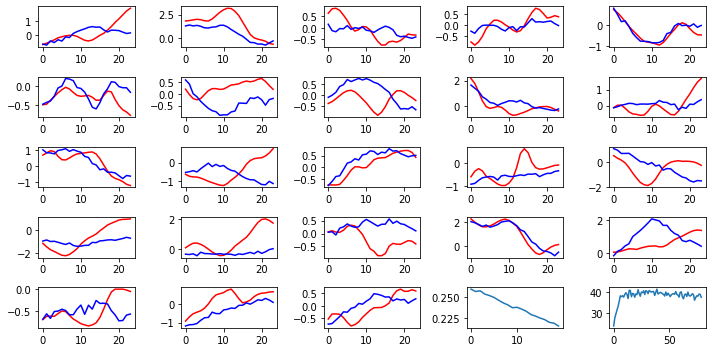

In [14]:
train(num_epochs=80)

In [15]:
# model.load_state_dict(torch.load('models/basemodel_best.pt'))

In [16]:
test_path = './tcdata/enso_round1_test_20210201/'

### load test data
files = os.listdir(test_path)
test_feas_dict = {}
for file in files:
    test_feas_dict[file] = np.load(test_path + file)

In [17]:
### 2. predict
test_predicts_dict = {}
for file_name, val in test_feas_dict.items():
    SST = np.expand_dims(val[:,:,:,0],axis=0)
    T300 = np.expand_dims(val[:,:,:,1],axis=0)
    Ua = np.expand_dims(val[:,:,:,2],axis=0)
    Va = np.expand_dims(val[:,:,:,3],axis=0)
    
    SST = np.nan_to_num(SST) # trans nan to 0
    T300 = np.nan_to_num(T300)
    Ua = np.nan_to_num(Ua)
    Va = np.nan_to_num(Va)
    
    data_list = [SST,T300,Ua,Va]
    SST,T300,Ua,Va = fit_data(data_list, fit=False)

    SST = torch.tensor(SST).to(device).float()
    T300 = torch.tensor(T300).to(device).float()
    Ua = torch.tensor(Ua).to(device).float()
    Va = torch.tensor(Va).to(device).float()
    
    result = model(SST, T300, Ua, Va).view(-1).detach().cpu().numpy()
    test_predicts_dict[file_name] = result

(20736, 4)


NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
### 3. save results
if os.path.exists('./result/'):  
    shutil.rmtree('./result/', ignore_errors=True)  
os.makedirs('./result/')
for file_name, val in test_predicts_dict.items(): 
    np.save('./result/' + file_name, val)

In [ ]:
def make_zip(res_dir='./result', output_dir='result.zip'):  
    z = zipfile.ZipFile(output_dir, 'w')  
    for file in os.listdir(res_dir):  
        if '.npy' not in file:
            continue
        z.write(res_dir + os.sep + file)  
    z.close()

In [ ]:
make_zip()